In [1]:
import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
numpyro.enable_x64()    
# posterior samples
import numpy as np
from scipy.stats import norm, gaussian_kde
import arviz as az
import jax
import jax.numpy as jnp
from jax import random
import jax.random as random
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
from datetime import datetime
from IPython.display import Markdown, display, HTML
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.lines import Line2D
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
def get_model_number(model_str):
    nums = re.findall(r'\d+', model_str)
    if nums:
        return int(nums[-1])
    else:
        return None
colors = ['black', 'blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

# --------------------------------------------------------
# global style
# --------------------------------------------------------
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "lines.linewidth": 1.5,
    "axes.grid": True,
    "grid.alpha": 0.3,
})


/Users/satoshan/.pyenv/versions/miniforge3-4.10.3-10/envs/forpymc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

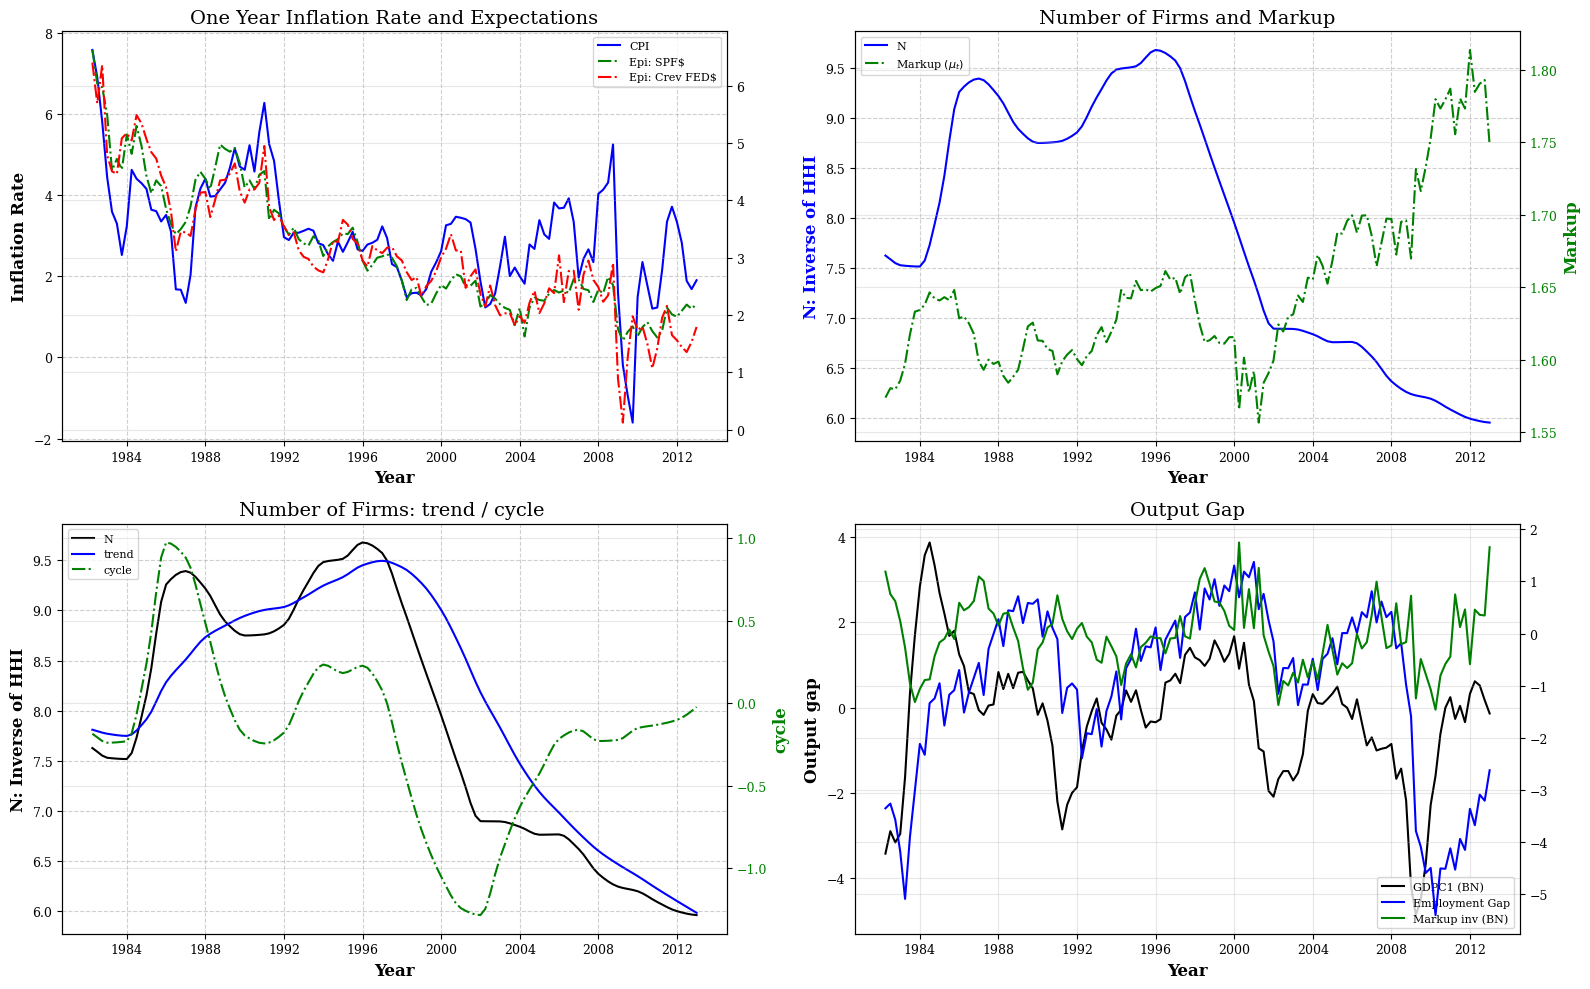

In [41]:
try:
    from scipy.interpolate import PchipInterpolator
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

# ---- helper functions ----
def to_datetime(s, fmt=None):
    return pd.to_datetime(s, format=fmt) if fmt else pd.to_datetime(s)

def yoy_pct(series_q):
    # Exact YoY percent change: 100*(x/lag4 - 1)
    return 100 * (series_q / series_q.shift(4) - 1)

def log_yoy(series_q):
    # Log-difference YoY ×100
    return 100 * (np.log(series_q) - np.log(series_q).shift(4))

def resample_quarterly_mean(df, date_col, value_cols):
    x = df.copy()
    x[date_col] = to_datetime(x[date_col])
    x = x.set_index(date_col).sort_index()
    q = x.resample("Q").mean()  # quarterly mean
    q.index.freq = "Q"
    return q[value_cols]

def annual_to_quarterly_pchip(df, date_col, value_col):
    """
    Convert annual data to quarterly using PCHIP interpolation.
    Falls back to time/polynomial interpolation if scipy unavailable.
    """
    x = df[[date_col, value_col]].copy()
    x[date_col] = to_datetime(x[date_col])
    x = x.set_index(date_col).sort_index()

    a = x.asfreq("YS")
    q_index = pd.date_range(a.index.min(), a.index.max(), freq="Q")
    q = pd.DataFrame(index=q_index, data=np.nan, columns=[value_col])
    q.index.freq = "Q"
    merged = a.reindex(a.index.union(q.index)).sort_index()

    if _HAS_SCIPY:
        xi = merged.index.view("i8")
        mask = merged[value_col].notna().values
        xx = xi[mask].astype(float)
        yy = merged.loc[mask, value_col].astype(float).values
        if len(xx) >= 2:
            f = PchipInterpolator(xx, yy)
            merged[value_col] = pd.Series(f(xi.astype(float)), index=merged.index)
        else:
            merged[value_col] = merged[value_col].interpolate(method="time")
    else:
        try:
            merged[value_col] = merged[value_col].interpolate(method="time")
            merged[value_col] = merged[value_col].interpolate(method="polynomial", order=3)
        except Exception:
            merged[value_col] = merged[value_col].interpolate()

    return merged.reindex(q_index)

# ---- SPF (xlsx) ----
spf = pd.read_excel("../data/inflation/Inflation.xlsx")
q_month = (spf["QUARTER"] * 3)
spf["DATE"] = pd.to_datetime(
    spf["YEAR"].astype(str) + "-" + q_month.astype(str) + "-01"
) + pd.offsets.MonthEnd(0)
spf["Epi_spf_gdp"] = spf["INFPGDP1YR"]
spf["Epi_spf_cpi"] = spf["INFCPI1YR"]
tt_spf = spf[["DATE", "Epi_spf_gdp", "Epi_spf_cpi"]].set_index("DATE").sort_index()
tt_spf.index = tt_spf.index.to_period("Q").to_timestamp(how="end")
tt_spf.index.freq = "Q"

# ---- CPI headline (monthly → quarterly → YoY%) ----
cpi = pd.read_csv("../data/inflation/CPIAUCSL.csv")
date_col = "DATE" if "DATE" in cpi.columns else ("observation_date" if "observation_date" in cpi.columns else None)
if date_col is None:
    raise ValueError("CPIAUCSL.csv must have DATE or observation_date column.")
tt_cpi_q = resample_quarterly_mean(cpi, date_col, ["CPIAUCSL"])
tt_cpi_q["pi_cpi"] = yoy_pct(tt_cpi_q["CPIAUCSL"])
tt_cpi_q = tt_cpi_q[["pi_cpi"]]

# ---- Core CPI (log YoY) ----
core = pd.read_csv("../data/inflation/CPILFESL.csv")
date_col = "DATE" if "DATE" in core.columns else ("observation_date" if "observation_date" in core.columns else None)
if date_col is None:
    raise ValueError("CPILFESL.csv must have DATE or observation_date column.")
tt_core_m = core[[date_col, "CPILFESL"]].copy()
tt_core_m[date_col] = to_datetime(tt_core_m[date_col])
tt_core_q = tt_core_m.set_index(date_col).sort_index().resample("Q").mean()
tt_core_q.index.freq = "Q"
tt_core_q["pi_cpi_core"] = log_yoy(tt_core_q["CPILFESL"])
tt_core = tt_core_q[["pi_cpi_core"]]

# ---- PCE headline (log YoY) ----
pce = pd.read_csv("../data/inflation/PCEPI.csv")
date_col = "DATE" if "DATE" in pce.columns else ("observation_date" if "observation_date" in pce.columns else None)
tt_pce_m = pce[[date_col, "PCEPI"]].copy()
tt_pce_m[date_col] = to_datetime(tt_pce_m[date_col])
tt_pce_q = tt_pce_m.set_index(date_col).sort_index().resample("Q").mean()
tt_pce_q.index.freq = "Q"
tt_pce_q["pi_pce"] = log_yoy(tt_pce_q["PCEPI"])
tt_pce = tt_pce_q[["pi_pce"]]

# ---- PCE core (log YoY) ----
pce_core = pd.read_csv("../data/inflation/PCEPILFE.csv")
date_col = "DATE" if "DATE" in pce_core.columns else ("observation_date" if "observation_date" in pce_core.columns else None)
tt_pce_core_m = pce_core[[date_col, "PCEPILFE"]].copy()
tt_pce_core_m[date_col] = to_datetime(tt_pce_core_m[date_col])
tt_pce_core_q = tt_pce_core_m.set_index(date_col).sort_index().resample("Q").mean()
tt_pce_core_q.index.freq = "Q"
tt_pce_core_q["pi_pce_core"] = log_yoy(tt_pce_core_q["PCEPILFE"])
tt_pce_core = tt_pce_core_q[["pi_pce_core"]]

# ---- N (annual → quarterly, cubic interp) ----
hhi = pd.read_csv("../data/competition/BN_N_26.csv")
hhi["N"] = hhi["original_series"]
hhi["year"] = pd.to_datetime(pd.to_datetime(hhi["date"]).dt.year.astype(str) + "-01-01")
tt_hhi_q = annual_to_quarterly_pchip(hhi.rename(columns={"year": "DATE"}), "DATE", "N")
# ---- N cycle and trend (annual → quarterly, cubic interp) ----
nb = pd.read_csv("../data/competition/BN_N_26.csv")
nb["N_BN_cycle"] = nb["cycle"]
nb["N_BN_trend"] = nb["trend"]
nb["DATE"] = pd.to_datetime(pd.to_datetime(nb["date"]).dt.year.astype(str) + "-01-01")
nb = nb[["DATE", "N_BN_cycle","N_BN_trend"]].dropna()
tt_nb_q = annual_to_quarterly_pchip(nb, "DATE", "N_BN_cycle")
tt_nb_trend_q = annual_to_quarterly_pchip(nb, "DATE", "N_BN_trend")

# ---- Markup levels ----
mk = pd.read_excel("../data/markup/nekarda_ramey_markups.xlsx")
mk["DATE"] = to_datetime(mk["qdate"])
mk["markup"] = mk["mu_bus"]
tt_mk = mk[["DATE", "markup"]].dropna().set_index("DATE").sort_index()
tt_mk.index = tt_mk.index.to_period("Q").to_timestamp(how="end")
tt_mk.index.freq = "Q"

# ---- BN inverse markup ----
mk_bn = pd.read_csv("../data/markup/BN_markup_inv.csv")
mk_bn["markup_BN_inv"] = mk_bn["cycle"]
mk_bn["DATE"] = to_datetime(mk_bn["date"])
tt_mk_bn = mk_bn[["DATE", "markup_BN_inv"]].dropna().set_index("DATE").sort_index()
tt_mk_bn.index = tt_mk_bn.index.to_period("Q").to_timestamp(how="end")
tt_mk_bn.index.freq = "Q"

# ---- Employment gap (NROU - UNRATENSA) ----
nairu = pd.read_csv("../data/unemp_gap/NROU.csv")
unemp = pd.read_csv("../data/unemp_gap/UNRATENSA.csv")

dc1 = "DATE" if "DATE" in nairu.columns else "observation_date"
dc2 = "DATE" if "DATE" in unemp.columns else "observation_date"

# Make sure both DATE columns are real datetimes (on both sides!)
n = nairu[[dc1, "NROU"]].rename(columns={dc1: "DATE"})
u = unemp[[dc2, "UNRATENSA"]].rename(columns={dc2: "DATE"})
n["DATE"] = pd.to_datetime(n["DATE"], errors="coerce")
u["DATE"] = pd.to_datetime(u["DATE"], errors="coerce")

tt_gap = (
    n.merge(u, on="DATE", how="outer")
     .set_index("DATE")
     .sort_index()
     .resample("Q").mean()
)
tt_gap.index.freq = "Q"
tt_gap["unemp_gap"] = tt_gap["NROU"] - tt_gap["UNRATENSA"]
tt_gap = tt_gap[["unemp_gap"]].dropna()

# ---- Output gap data (BN filter) ----
out = pd.read_csv("../data/output_gap/BN_filter_GDPC1_quaterly.csv")
out["output_BN"] = out["GDPC1_transformed_series"]
out["output_gap_BN"] = out["cycle"]
out["output"] = np.log(out["GDPC1_original_series"] * 0.01)
out["DATE"] = to_datetime(out["date"])
out["output_trend_BN"] = out["output_BN"] - out["output_gap_BN"]
tt_out = (
    out[["DATE", "output_BN", "output_gap_BN", "output_trend_BN", "output"]]
    .dropna()
    .set_index("DATE")
    .sort_index()
)
tt_out.index = tt_out.index.to_period("Q").to_timestamp(how="end")
tt_out.index.freq = "Q"

# ---- Oil prices (WTI deflated by CPI, log YoY) ----
oil = pd.read_csv("../data/others/WTISPLC_CPIAUCSL.csv")
dc = "DATE" if "DATE" in oil.columns else "observation_date"
tt_oil = oil[[dc, "WTISPLC_CPIAUCSL"]].copy()
tt_oil[dc] = to_datetime(tt_oil[dc])
tt_oil = tt_oil.set_index(dc).sort_index().resample("Q").mean()
tt_oil.index.freq = "Q"
tt_oil["log_oil"] = np.log(tt_oil["WTISPLC_CPIAUCSL"])
tt_oil["oil"] = tt_oil["log_oil"] - tt_oil["log_oil"].shift(4)
tt_oil = tt_oil[["oil"]]

# ---- Inflation expectations (monthly → quarterly mean ×100) ----
epi = pd.read_csv("../data/inflation/one_year_inflation_expectation.csv")
epi["DATE"] = to_datetime(epi["Date"], fmt="%Y-%m-%d")
epi.astype({"DATE": str}).set_index("DATE", inplace=True)
epi["Epi"] = epi[" Epi"] * 100
epi = epi[["DATE","Epi"]]
tt_epi_m = pd.DataFrame({"DATE": epi["DATE"], "Epi": epi["Epi"]}).set_index("DATE").sort_index()
tt_epi = tt_epi_m.resample("Q").mean()

def as_qe_midnight(df):
    """Force index to quarter-end at 00:00:00 (no nanoseconds)."""
    out = df.copy()
    # ensure datetime index
    out.index = pd.to_datetime(out.index)
    # convert to quarter periods then back to Timestamps at end-of-quarter
    out.index = pd.PeriodIndex(out.index, freq="Q").to_timestamp(how="end").normalize()
    out.index.name = "DATE"
    # freq is not needed; leave it unset to avoid surprises
    out.index.freq = None
    return out
dfs = [
    tt_cpi_q, tt_epi, tt_spf, tt_core, tt_out, tt_hhi_q, tt_nb_q,tt_nb_trend_q,
    tt_mk, tt_pce_core, tt_pce, tt_mk_bn, tt_gap, tt_oil
]
dfs = [as_qe_midnight(d) for d in dfs] 
data = pd.concat(dfs, axis=1).sort_index()

data.index = data.index.to_period("Q").to_timestamp(how="end")
data.index.freq = "Q"

# ---- Add lagged variables ----
for col in ["pi_cpi", "pi_cpi_core", "pi_pce", "pi_pce_core", "N_BN_trend"]:
    if col in data.columns:
        data[f"{col}_prev"] = data[col].shift(1)

    
data = data.loc["1982-01-01":"2012-12-31"]
data['DATE'] = pd.to_datetime(data.index)
# --- 2×2 graph ---
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# --- 1. Inflation and Expected Inflation ---
ax1= axs[0, 0]
ax1_left = ax1
ax1_right = ax1_left.twinx()
ax1_left.plot(data["DATE"], data["pi_cpi"], label=r'CPI', color='blue')
ax1_right.plot(data["DATE"], data["Epi_spf_cpi"], label=r'Epi: SPF$', linestyle='-.', color='green')
ax1_right.plot(data["DATE"], data["Epi"], label=r'Epi: Crev FED$', linestyle='-.', color='red')
ax1_left.set_xlabel('Year', fontsize=12, weight='bold')
ax1_left.set_ylabel('Inflation Rate', fontsize=12, weight='bold', color = 'black')
ax1_left.grid(True, linestyle='--', alpha=0.6)
ax1_left.set_title('One Year Inflation Rate and Expectations', fontsize=14)
lines = ax1_left.get_lines() + ax1_right.get_lines()
labels = [line.get_label() for line in lines]
ax1_left.legend(lines, labels, loc='upper right', fontsize=8)

# --- 2. Number of Firms and Markup ---
ax2 = axs[0, 1]
ax2_left = ax2
ax2_right = ax2_left.twinx()
ax2_left.plot(data["DATE"], data["N"], label=r'N', color='blue')
ax2_right.plot(data["DATE"], data["markup"], label=r'Markup $(\mu_{t})$', linestyle='-.', color='green')
ax2_left.set_xlabel('Year', fontsize=12, weight='bold')
ax2_left.set_ylabel('N: Inverse of HHI', fontsize=12, weight='bold', color = 'blue')
ax2_right.set_ylabel('Markup', fontsize=12, weight='bold', color='green')
ax2_right.tick_params(axis='y', labelcolor='green')
ax2_left.grid(True, linestyle='--', alpha=0.6)
ax2_left.set_title('Number of Firms and Markup', fontsize=14)
lines = ax2_left.get_lines() + ax2_right.get_lines()
labels = [line.get_label() for line in lines]
ax2_left.legend(lines, labels, loc='upper left', fontsize=8)

# --- 3.  Number of Firms: trend / cycle ---
ax3 = axs[1, 0]
ax3_left = ax3
ax3_right = ax3_left.twinx()
ax3_left.plot(data["DATE"], data["N"], label='N', color='black')
ax3_left.plot(data["DATE"], data["N_BN_trend"], label='trend', color='blue')
ax3_right.plot(data["DATE"],data["N_BN_cycle"], label=r'cycle', linestyle='-.', color='green')
ax3_left.set_xlabel('Year', fontsize=12, weight='bold')
ax3_left.set_ylabel('N: Inverse of HHI', fontsize=12, weight='bold')
ax3_right.set_ylabel('cycle', fontsize=12, weight='bold', color='green')
ax3_right.tick_params(axis='y', labelcolor='green')
ax3_left.grid(True, linestyle='--', alpha=0.6)
ax3_left.set_title('Number of Firms: trend / cycle ', fontsize=14)
lines = ax3_left.get_lines() + ax3_right.get_lines()
labels = [line.get_label() for line in lines]
ax3_left.legend(lines, labels, loc='upper left', fontsize=8)

# --- 5. Output Gaps ------
ax5 = axs[1, 1]
ax5_left = ax5
ax5_right = ax5_left.twinx()
ax5_left.set_ylabel('Output gap', fontsize=12, weight='bold', color='black')
ax5_left.plot(data["DATE"], data["output_gap_BN"], label=r'GDPC1 (BN)', color='black')
ax5_right.plot(data["DATE"], data["unemp_gap"], label=r'Employment Gap', color='blue')
ax5_right.plot(data["DATE"], data["markup_BN_inv"], label=r'Markup inv (BN)', color='green')
ax5_left.set_title('Output Gap', fontsize=14)
ax5_left.set_xlabel('Year', fontsize=12, weight='bold')
lines = ax5_left.get_lines() + ax5_right.get_lines()
labels = [line.get_label() for line in lines]
ax5_left.legend(lines, labels, loc='lower right', fontsize=8)
# --- Layout ---
plt.tight_layout()
plt.show()

# Prior distributions

In [3]:
alpha_mu = 0.5
alpha_sigma = 1
kappa_mu = 0
kappa_sigma = 1
theta_mu = 0
theta_sigma = 1
delta_mu = 0
delta_sigma = 1
beta_mu = 0
beta_sigma = 1
def set_prior_distributions():
    priors = {
        # NKPC params
        "alpha"      : dist.Normal(alpha_mu, alpha_sigma),
        "kappa"      : dist.Normal(kappa_mu, kappa_sigma),
        "kappa0"     : dist.Normal(kappa_mu, kappa_sigma),
        "theta"      : dist.Normal(theta_mu, theta_sigma), 
        "delta"      : dist.Normal(delta_mu, delta_sigma),  
        "beta"       : dist.Normal(beta_mu, beta_sigma), 
        # Sigma
        "n"          : dist.Normal(0, 1), 
        # non informative priors
        "sigma_u"    : dist.InverseGamma(0.001, 0.001),  
        "sigma_eps"  : dist.InverseGamma(0.001, 0.001),  
        "sigma_v"    : dist.InverseGamma(0.001, 0.001),  
        "sigma_mu"   : dist.InverseGamma(0.001, 0.001),  
        "sigma_e"    : dist.InverseGamma(0.001, 0.001),  
        "sigma_eta"  : dist.InverseGamma(0.001, 0.001),  
    }
    return priors

warmup= 1000
samples=9000
chains = 2
rng_key = jax.random.PRNGKey(0)
rng_keys = jax.random.split(rng_key, chains)

# for MCMC
pi = jnp.array(data['pi_cpi'],dtype=jnp.float64)
pi_prev = jnp.array(data['pi_cpi_prev'],dtype=jnp.float64)
pi_expect = jnp.array(data['Epi_spf_cpi'],dtype=jnp.float64)
N = jnp.array(data['N'],dtype=jnp.float64)
Nhat = jnp.array(data['N_BN_cycle'],dtype=jnp.float64)
Nbar = jnp.array(data['N_BN_trend'],dtype=jnp.float64)
Y = jnp.array(data['output'],dtype=jnp.float64)
x_markup = jnp.array(1/data['markup'],dtype=jnp.float64)
x_output_gap = jnp.array(data['output_gap_BN'],dtype=jnp.float64)
x_markup_bn = jnp.array(data['markup_BN_inv'],dtype=jnp.float64)
x_unempgap = jnp.array(data['unemp_gap'],dtype=jnp.float64)

# Fixed kappa

## CES
$$\pi_{t}	=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+\kappa_{t}x_{t}+v_{t}$$

In [4]:
def model_0(pi, pi_prev, pi_expect, x):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha", priors["alpha"])
    kappa = numpyro.sample("kappa", priors["kappa"])
    # Sigma
    sigma_v = numpyro.sample("sigma_v", priors["sigma_v"])
    # model
    pi_pred = alpha * pi_prev + (1-alpha) * pi_expect + kappa * x
    numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_v), obs=pi)

In [5]:
# fixed kappa
# CES
# Define all x-variables you want to test
x_dict = {
    "CES_output_gap": x_output_gap,
    "CES_markup": x_markup,
    "CES_markup_BN": x_markup_bn,
    "CES_unemp_gap": x_unempgap,
}
# 1) model
dict_idata = {}
div_rows = []  # divergence 
params = ["alpha", "kappa"] 
print("=== Run models ===")
for model_name, x in x_dict.items():
    print(f"Running NKPC model: {model_name}")
    kernel = NUTS(model_0, target_accept_prob=0.995)
    mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
    mcmc.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x)
    idata = az.from_numpyro(mcmc)
    dict_idata[model_name] = idata
    # Divergence diagnostics
    diverging = idata.sample_stats["diverging"].values
    ratio_div = float(np.mean(diverging))
    print(f"Divergence ratio for {model_name}: {ratio_div:.4%}")
print("\n=== All models finished ===\n")

=== Run models ===
Running NKPC model: CES_output_gap


sample: 100%|██████████| 10000/10000 [00:01<00:00, 9541.04it/s, 15 steps of size 2.16e-01. acc. prob=0.99]


Divergence ratio for CES_output_gap: 0.0000%
Running NKPC model: CES_markup


sample: 100%|██████████| 10000/10000 [00:01<00:00, 9654.83it/s, 15 steps of size 2.30e-01. acc. prob=0.99]


Divergence ratio for CES_markup: 0.0000%
Running NKPC model: CES_markup_BN


sample: 100%|██████████| 10000/10000 [00:00<00:00, 10210.96it/s, 15 steps of size 2.27e-01. acc. prob=0.99]


Divergence ratio for CES_markup_BN: 0.0000%
Running NKPC model: CES_unemp_gap


sample: 100%|██████████| 10000/10000 [00:01<00:00, 9593.73it/s, 15 steps of size 2.28e-01. acc. prob=0.99]

Divergence ratio for CES_unemp_gap: 0.0000%

=== All models finished ===



## HSA
$$\pi_{t}	=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+\kappa_{t}x_{t}-\theta\hat{N}_{t}+v_{t}\\$$

In [6]:
def model_01(pi, pi_prev, pi_expect, x, Nhat):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha", priors["alpha"])
    kappa = numpyro.sample("kappa", priors["kappa"])
    theta = numpyro.sample("theta", priors["theta"])
    # Sigma
    sigma_v = numpyro.sample("sigma_v", priors["sigma_v"])
    # model
    pi_pred = alpha * pi_prev + (1-alpha) * pi_expect + kappa * x - theta * Nhat
    numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_v), obs=pi)

In [7]:
# 1) model
x_dict = {
    "HSA_output_gap": x_output_gap,
    "HSA_markup": x_markup,
    "HSA_markup_BN": x_markup_bn,
    "HSA_unemp_gap": x_unempgap,
}
params = ["alpha", "kappa", "theta"] 
print("=== Run models ===")
for model_name, x in x_dict.items():
    print(f"Running NKPC model: {model_name}")
    kernel = NUTS(model_01, target_accept_prob=0.995)
    mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
    mcmc.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, Nhat=Nhat)
    idata = az.from_numpyro(mcmc)
    dict_idata[model_name] = idata
    # Divergence diagnostics
    diverging = idata.sample_stats["diverging"].values
    ratio_div = float(np.mean(diverging))
    print(f"Divergence ratio for {model_name}: {ratio_div:.4%}")
print("\n=== All models finished ===\n")

=== Run models ===
Running NKPC model: HSA_output_gap


sample: 100%|██████████| 10000/10000 [00:01<00:00, 8873.79it/s, 15 steps of size 1.93e-01. acc. prob=0.99]


Divergence ratio for HSA_output_gap: 0.0000%
Running NKPC model: HSA_markup


sample: 100%|██████████| 10000/10000 [00:01<00:00, 8980.33it/s, 15 steps of size 1.90e-01. acc. prob=0.99]


Divergence ratio for HSA_markup: 0.0000%
Running NKPC model: HSA_markup_BN


sample: 100%|██████████| 10000/10000 [00:01<00:00, 8861.78it/s, 15 steps of size 1.91e-01. acc. prob=0.99]


Divergence ratio for HSA_markup_BN: 0.0000%
Running NKPC model: HSA_unemp_gap


sample: 100%|██████████| 10000/10000 [00:01<00:00, 9159.17it/s, 15 steps of size 2.29e-01. acc. prob=0.99]


Divergence ratio for HSA_unemp_gap: 0.0000%

=== All models finished ===



## HSA Joint decomposition
$$\pi_{t}	=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+\kappa x_{t}-\theta\hat{N}_{t}+v_{t}\\
N_{t}	=\hat{N_{t}}+\bar{N_{t}}\\
\hat{N_{t}}	=\rho_{1}\hat{N}_{t-1}+\rho_{2}\hat{N}_{t-2}+u_{t}\\
\bar{N_{t}}	=n+\bar{N}_{t-1}+\epsilon_{t}$$

In [8]:
def model_1(pi, pi_prev, pi_expect, x, N, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa = numpyro.sample("kappa", priors["kappa"])
    theta = numpyro.sample("theta", priors["theta"])
    # State equation (N) params
    r = numpyro.sample("r", dist.Uniform(-1,1))      
    p = numpyro.sample("p", dist.Uniform(0.1, 0.9))  
    rho_1 = 2 * r * jnp.cos(jnp.pi * p)
    rho_2 = -r ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    n = numpyro.sample("n", priors["n"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_u  = numpyro.sample("sigma_u", priors["sigma_u"])      
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) 
    # initial 
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1))   # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, .05))    # Nhat init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, .05))    # Nhat init
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        t = carry[3]
        # state equation
        # trend 
        Nbar_t = numpyro.sample("Nbar", dist.Normal(n + Nbar_prev, sigma_eps))
        # N (Nbar + Nhat = observed N)
        N_hat_obs = N[t] - Nbar_t
        # cycle
        N_hat_pred = rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2
        Nhat_t = numpyro.sample("Nhat_t", dist.Normal(N_hat_pred, sigma_u), obs=N_hat_obs)
        numpyro.deterministic("Nhat", Nhat_t) 
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa * x[t] - theta * Nhat_t
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat_t, Nhat_prev_1 , t], None
    scan(transition, [bar_N_0, hat_N_0, hat_N_1, t], timesteps)

In [9]:
# Define all x-variables you want to test
x_dict = {
    "HSA_decomp_output_gap": x_output_gap,
    "HSA_decomp_markup": x_markup,
    "HSA_decomp_markup_BN": x_markup_bn,
    "HSA_decomp_unemp_gap": x_unempgap,
}
# 1) model
div_rows = []  # divergence 
params = ["alpha", "kappa", "theta", "rho_1","rho_2", "n"] 
print("=== Run models ===")
for model_name, x in x_dict.items():
    print(f"Running NKPC model: {model_name}")
    kernel = NUTS(model_1, target_accept_prob=0.995)
    mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
    mcmc.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, N=N, l=len(pi))
    idata = az.from_numpyro(mcmc)
    dict_idata[model_name] = idata
    # Divergence diagnostics
    diverging = idata.sample_stats["diverging"].values
    ratio_div = float(np.mean(diverging))
    print(f"Divergence ratio for {model_name}: {ratio_div:.4%}")
print("\n=== All models finished ===\n")

=== Run models ===
Running NKPC model: HSA_decomp_output_gap


sample: 100%|██████████| 10000/10000 [01:16<00:00, 130.41it/s, 1023 steps of size 8.26e-03. acc. prob=0.99]


Divergence ratio for HSA_decomp_output_gap: 0.0000%
Running NKPC model: HSA_decomp_markup


sample: 100%|██████████| 10000/10000 [01:17<00:00, 128.96it/s, 1023 steps of size 8.50e-03. acc. prob=0.99]


Divergence ratio for HSA_decomp_markup: 0.0000%
Running NKPC model: HSA_decomp_markup_BN


sample: 100%|██████████| 10000/10000 [01:17<00:00, 129.10it/s, 1023 steps of size 8.60e-03. acc. prob=0.99]


Divergence ratio for HSA_decomp_markup_BN: 0.0000%
Running NKPC model: HSA_decomp_unemp_gap


sample: 100%|██████████| 10000/10000 [01:15<00:00, 131.79it/s, 511 steps of size 8.89e-03. acc. prob=0.99]


Divergence ratio for HSA_decomp_unemp_gap: 0.0000%

=== All models finished ===



## Results

model,alpha,kappa,theta,n,rho_1,rho_2,sigma_v,sigma_eps,sigma_u
CES_markup,0.6620,-0.1240,nan,nan,nan,nan,0.6750,nan,nan
CES_markup_BN,0.6650,-0.0130,nan,nan,nan,nan,0.6790,nan,nan
CES_output_gap,0.7070,0.0940,nan,nan,nan,nan,0.6640,nan,nan
CES_unemp_gap,0.6510,0.0810,nan,nan,nan,nan,0.6600,nan,nan
HSA_decomp_markup,0.6530,-0.1230,0.1160,-0.0150,1.7850,-0.8840,0.6750,0.0590,0.0360
HSA_decomp_markup_BN,0.6540,0.0030,0.1200,-0.0150,1.7850,-0.8840,0.6790,0.0590,0.0360
HSA_decomp_output_gap,0.6950,0.1000,0.2000,-0.0150,1.7850,-0.8840,0.6630,0.0580,0.0370
HSA_decomp_unemp_gap,0.6300,0.0910,0.2760,-0.0140,1.7850,-0.8840,0.6560,0.0580,0.0370
HSA_markup,0.6360,-0.1870,0.2040,nan,nan,nan,0.6690,nan,nan
HSA_markup_BN,0.6470,0.0040,0.1280,nan,nan,nan,0.6780,nan,nan


model,SDDR_BF01_kappa,SDDR_BF01_theta
CES_output_gap,2.114,nan
CES_markup,4.512,nan
CES_markup_BN,10.28,nan
CES_unemp_gap,1.145,nan
HSA_output_gap,1.181,2.943
HSA_markup,2.009,2.097
HSA_markup_BN,10.18,4.721
HSA_unemp_gap,1.119,4.373
HSA_decomp_output_gap,1.438,2.877
HSA_decomp_markup,4.902,3.678


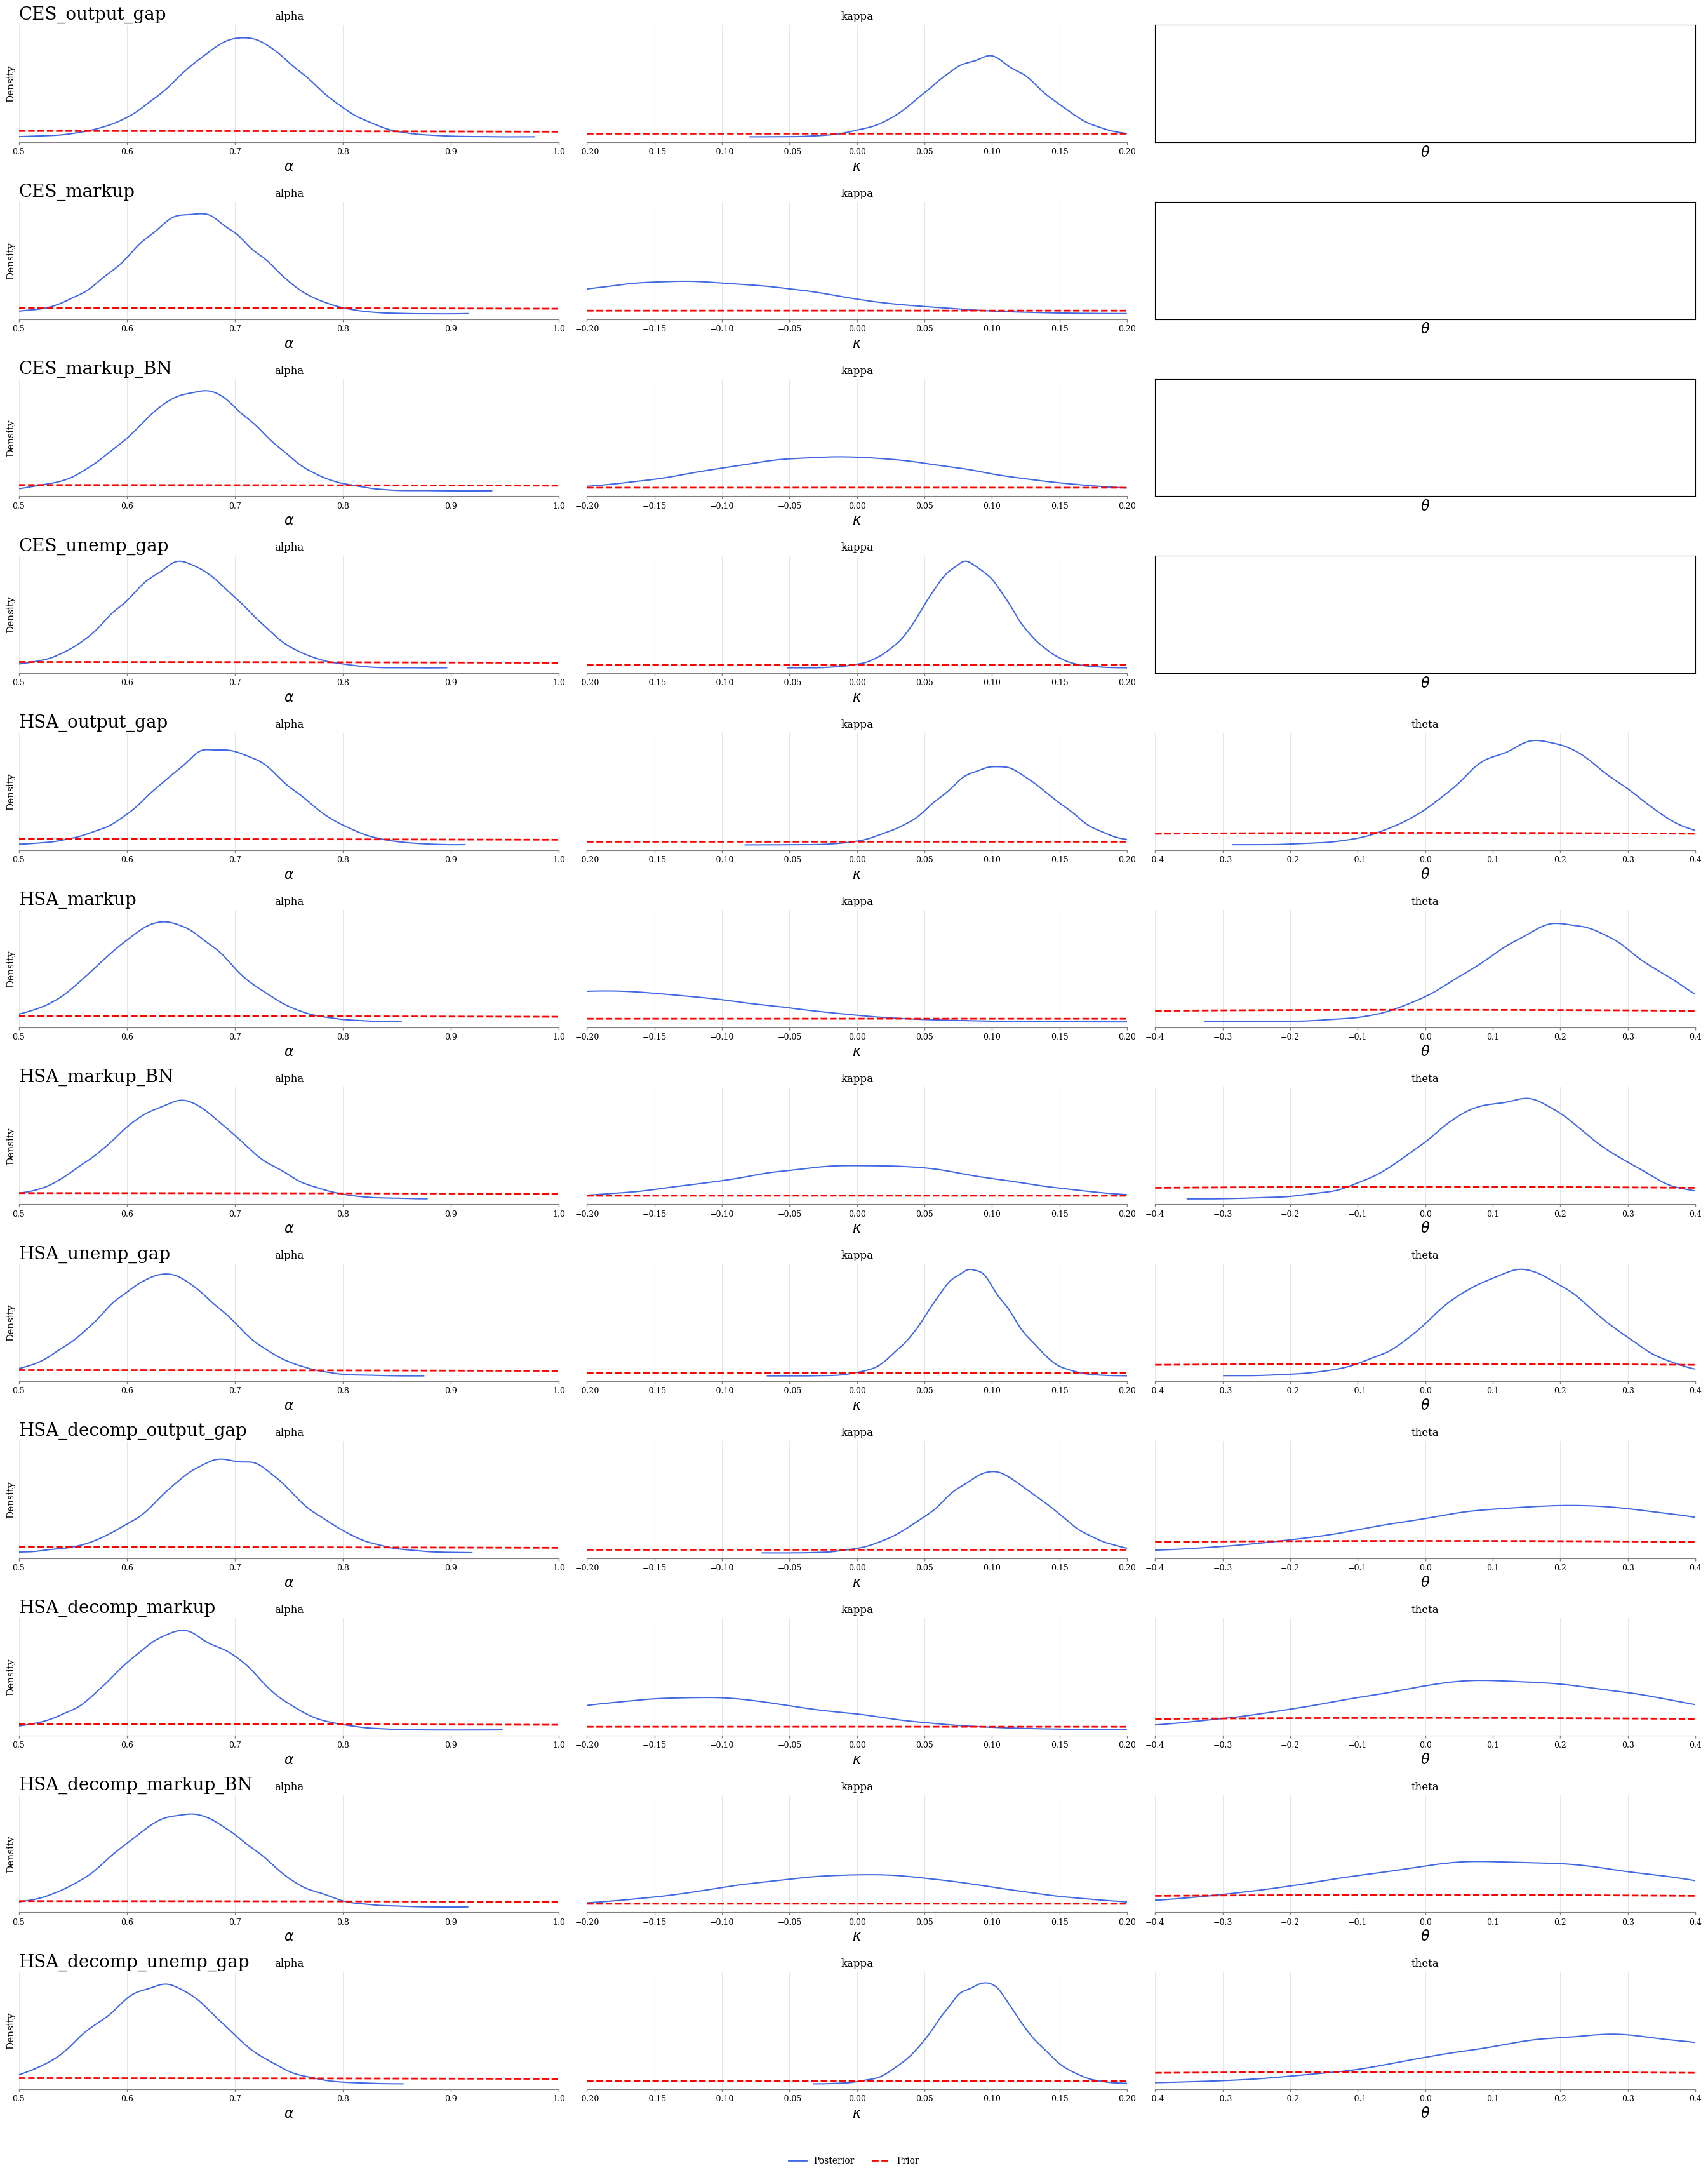

<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_loo (deviance)', ylabel='ranked models'>

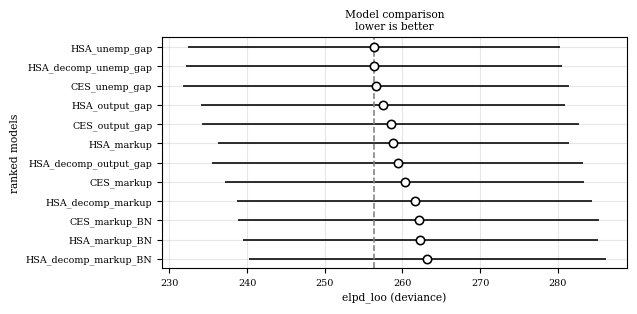

In [10]:
def sddr_kappa(idata):
    """BF_01 = posterior_density_at_0 / prior_density_at_0"""
    # posterior draws of kappa
    post = np.asarray(idata.posterior["kappa"]).ravel()
    post = post[np.isfinite(post)]
    if post.size < 10:
        return np.nan  # safety

    # posterior density at 0 (KDE)
    kde = gaussian_kde(post)
    post_at0 = float(kde.evaluate([0.0])[0])
    # prior density at 0
    prior_at0 = norm.pdf(0.0, loc=kappa_mu, scale=kappa_sigma)
    return post_at0 / max(prior_at0, 1e-300)

def sddr_theta(idata):
    """BF_01 = posterior_density_at_0 / prior_density_at_0"""
    # posterior draws of kappa
    post = np.asarray(idata.posterior["theta"]).ravel()
    post = post[np.isfinite(post)]
    if post.size < 10:
        return np.nan  # safety
    # posterior density at 0 (KDE)
    kde = gaussian_kde(post)
    post_at0 = float(kde.evaluate([0.0])[0])
    # prior density at 0
    prior_at0 = norm.pdf(0.0, loc=theta_mu, scale=theta_sigma)
    return post_at0 / max(prior_at0, 1e-300)
def plot_prior_posterior_grid(idatas, labels, params=("kappa","alpha","theta"),
                              figsize=(9,2.8), xlims=None):
    assert len(idatas) == len(labels)
    n_rows, n_cols = len(idatas), len(params)
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(figsize[0]*n_cols, figsize[1]*n_rows),
                             squeeze=False, sharey='col')

    priors = {"alpha": (alpha_mu, alpha_sigma),
              "kappa": (kappa_mu, kappa_sigma),
              "theta": (theta_mu, theta_sigma),
              "delta": (delta_mu, delta_sigma)}

    for i, (idata, label_row) in enumerate(zip(idatas, labels)):
        avail = set(idata.posterior.data_vars) if "posterior" in idata.__dict__ else set()
        for j, param in enumerate(params):
            ax = axes[i, j]
            if param in avail:
                az.plot_posterior(idata, var_names=[param], point_estimate=None,
                                  hdi_prob="hide", kind="kde", color="royalblue", ax=ax)
                if param in priors:
                    mu, sigma = priors[param]
                    if xlims and param in xlims:
                        xmin, xmax = xlims[param]
                    else:
                        xmin, xmax = mu - 5*sigma, mu + 5*sigma
                    x = np.linspace(xmin, xmax, 1000)
                    y = norm.pdf(x, mu, sigma)
                    ax.plot(x, y, "r--", lw=2, label="Prior")
            else:
                ax.set_xticks([]); ax.set_yticks([])

            if j == 0:
                ax.set_ylabel("Density", fontsize=11)
                ax.set_title(label_row, fontsize=20, loc="left")
            ax.set_xlabel({"kappa": r"$\kappa$", "alpha": r"$\alpha$",
                           "theta": r"$\theta$", "delta": r"$\delta$"}.get(param, param), fontsize=16)
            if xlims and param in xlims: ax.set_xlim(xlims[param])

    legend_handles = [Line2D([0],[0], color="royalblue", lw=2, label="Posterior"),
                      Line2D([0],[0], color="red", lw=2, ls="--", label="Prior")]
    fig.legend(handles=legend_handles, fontsize=10, loc="lower center",
               ncol=2, frameon=False, bbox_to_anchor=(0.5, -0.02))
    plt.tight_layout()
    return fig


show_hdi = False

target_params = ["alpha", "kappa", "theta", "n", "rho_1", "rho_2", 
                 "sigma_v", "sigma_eps", "sigma_u"]

# ------- Summary table -------
summ_list = []
for model_name, idata in dict_idata.items():

    present = set(idata.posterior.data_vars)
    selected = list(present.intersection(target_params))
    if len(selected) == 0:
        continue

    # ArviZ summary
    s = az.summary(idata, var_names=selected, hdi_prob=0.95)

    s["param"] = s.index
    s["model"] = model_name
    s = s.reset_index(drop=True)
    s = s[["model", "param", "mean", "hdi_2.5%", "hdi_97.5%"]]

    summ_list.append(s)

summary_long = pd.concat(summ_list, ignore_index=True)

# ---- HDI on/off ----
if show_hdi:
    summary_long["value"] = summary_long.apply(
        lambda r: f"{r['mean']:.4f} [{r['hdi_2.5%']:.4f}, {r['hdi_97.5%']:.4f}]",
        axis=1
    )
else:
    summary_long["value"] = summary_long["mean"].map(lambda x: f"{x:.4f}")

# pivot
summary_wide = (
    summary_long.pivot_table(
        index="model",
        columns="param",
        values="value",
        aggfunc="first",
    )
    .reindex(columns=target_params)
    .reset_index()
    .rename_axis(None, axis=1)
)

display(HTML("<h3>Summary</h3>"))
display(summary_wide.style.hide(axis="index"))

# SDDR（kappa / theta）table
sddr_rows = []
for model_name, idata in dict_idata.items():
    try:
        bf01_kappa = sddr_kappa(idata)
    except Exception:
        bf01_kappa = np.nan
    try:
        bf01_theta = sddr_theta(idata)
    except Exception:
        bf01_theta = np.nan
    sddr_rows.append({
        "model": model_name,
        "SDDR_BF01_kappa": bf01_kappa,
        "SDDR_BF01_theta": bf01_theta,
    })

df_sddr = pd.DataFrame(sddr_rows)
df_sddr = pd.DataFrame(sddr_rows)
df_sddr["SDDR_BF01_kappa"] = df_sddr["SDDR_BF01_kappa"].map(lambda v: f"{v:.4}")
df_sddr["SDDR_BF01_theta"] = df_sddr["SDDR_BF01_theta"].map(lambda v: f"{v:.4}")


display(HTML("<h3>SDDR: kappa: Bayes Factor (BF01)</h3>"))
display(df_sddr.style.hide(axis="index"))

display(HTML("<h3>prior vs posterior </h3>"))
# 6) prior vs posterior 
params = ("alpha", "kappa", "theta")
try:
    idatas = [idata for _, idata in dict_idata.items()]
    labels  = [name for name, _ in dict_idata.items()]
    fig = plot_prior_posterior_grid(
            idatas=idatas,
            labels=labels,
            params=params,
            xlims={"kappa": (-0.2, 0.2), "alpha": (0.5, 1.0), "theta": (-0.4, 0.4)},
        )
    plt.show()
except Exception as e:
    print(f"[plot_prior_posterior_grid] error: {e}")


display(HTML("<h3>WAIC</h3>"))
df_waic = az.compare(dict_idata, var_name="pi_obs" ,ic='loo', scale='deviance')
az.plot_compare(df_waic, figsize=(6, 3))

# Time-varying kappa

- case 1 (deterministic)
$$
\kappa_{t}	=\kappa_{t-1}+\delta \Delta \bar{N}_{t}
$$

- case 2 (stochastic followed by normal distribution)
$$
\kappa_{t} \sim Normal(\kappa_{t-1}+\delta \Delta \bar{N}_{t}, \sigma_e^2)
$$

- case 3 (stochastic followed by truncated normal distribution)
$$
\kappa_{t} \sim TruncNormal(\kappa_{t-1}+\delta \Delta \bar{N}_{t}, \sigma_e^2, low=0)
$$

In [38]:
# models
## =================================================================================
## case 0
def model_2_case0(pi, pi_prev, pi_expect, x, Nbar, Nhat, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa0 = numpyro.sample("kappa0", priors["kappa0"])
    theta = numpyro.sample("theta", priors["theta"])
    delta = numpyro.sample("delta", dist.Normal(0, 1))
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])  
    sigma_e = numpyro.sample("sigma_e", priors["sigma_e"])      
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):        
        kappa_prev = carry[0]
        t = carry[1]        
        # kappa      
        kappa_t = numpyro.sample("kappa_t", dist.Normal(kappa_prev + delta * Nbar[t], sigma_e))
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat[t]
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [kappa_t , t], None
    scan(transition, [kappa0, t], timesteps)
## case 0
def model_2_case01(pi, pi_prev, pi_expect, x, Nbar, Nhat, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa0 = numpyro.sample("kappa0", priors["kappa0"])
    theta = numpyro.sample("theta", priors["theta"])
    delta = numpyro.sample("delta", dist.Normal(0, 1))
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])  
    sigma_e = numpyro.sample("sigma_e", priors["sigma_e"])      
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):        
        kappa_prev = carry[0]
        t = carry[1]        
        # kappa      
        kappa_t = numpyro.deterministic("kappa_t", kappa_prev + delta * Nbar[t])
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat[t]
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [kappa_t , t], None
    scan(transition, [kappa0, t], timesteps)
## =================================================================================
## case 1 (deterministic)
def model_2_case1(pi, pi_prev, pi_expect, x, Nbar, Nhat, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa0 = numpyro.sample("kappa0", priors["kappa0"])
    theta = numpyro.sample("theta", priors["theta"])
    delta = numpyro.sample("delta", dist.Normal(0, 1))
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):        
        kappa_prev = carry[0]
        t = carry[1]        
        # kappa      
        dNbar = jnp.concatenate([jnp.array([0.0]), jnp.diff(Nbar)])
        kappa_t = kappa_prev + delta * dNbar[t]
        numpyro.deterministic("kappa_t", kappa_t)         
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat[t]
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [kappa_t , t], None
    scan(transition, [kappa0, t], timesteps)
## =================================================================================
## case 2 (sample from Normal distribution)
def model_2_case2(pi, pi_prev, pi_expect, x, Nbar, Nhat, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa0 = numpyro.sample("kappa0", priors["kappa0"])
    theta = numpyro.sample("theta", priors["theta"])
    delta = numpyro.sample("delta", priors["delta"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])  
    sigma_e  = numpyro.sample("sigma_e", priors["sigma_e"])    
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):        
        kappa_prev = carry[0]
        t = carry[1]            
        # kappa        
        dNbar = jnp.concatenate([jnp.array([0.0]), jnp.diff(Nbar)])
        kappa_t = numpyro.sample("kappa_t", dist.Normal(kappa_prev + delta * dNbar[t], sigma_e))        
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat[t]
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [kappa_t , t], None
    scan(transition, [kappa0, t], timesteps)
## =================================================================================
## case 3 (sample from TruncatedNormal distribution)
def model_2_case3(pi, pi_prev, pi_expect, x, Nbar, Nhat, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa0 = numpyro.sample("kappa0", priors["kappa0"])
    theta = numpyro.sample("theta", priors["theta"])
    delta = numpyro.sample("delta", priors["delta"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])  
    sigma_e  = numpyro.sample("sigma_e", priors["sigma_e"])    
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):        
        kappa_prev = carry[0]
        t = carry[1]            
        # kappa        
        dNbar = jnp.concatenate([jnp.array([0.0]), jnp.diff(Nbar)])
        kappa_t = numpyro.sample("kappa_t", dist.TruncatedNormal(loc=kappa_prev + delta * dNbar[t], scale=sigma_e, low=0))        
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat[t]
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [kappa_t , t], None
    scan(transition, [kappa0, t], timesteps)


In [ ]:
print("case 1")
x_dict = {
    "HSA_tv1_output_gap": x_output_gap,
    "HSA_tv1_markup": x_markup,
    "HSA_tv1_markup_BN": x_markup_bn,
    "HSA_tv1_unemp_gap": x_unempgap,
}
# 1) model
div_rows = []  # divergence 
print("=== Run models ===")
for model_name, x in x_dict.items():
    print(f"Running NKPC model: {model_name}")
    kernel = NUTS(model_2_case1, target_accept_prob=0.995)
    mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
    mcmc.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, Nhat=Nhat, Nbar=Nbar, l=len(pi))
    idata = az.from_numpyro(mcmc)
    dict_idata[model_name] = idata
    # Divergence diagnostics
    diverging = idata.sample_stats["diverging"].values
    ratio_div = float(np.mean(diverging))
    print(f"Divergence ratio for {model_name}: {ratio_div:.4%}")
print("\n=== All models finished ===\n")

print("case 2")
x_dict = {
    "HSA_tv2_output_gap": x_output_gap,
    "HSA_tv2_markup": x_markup,
    "HSA_tv2_markup_BN": x_markup_bn,
    "HSA_tv2_unemp_gap": x_unempgap,
}
# 1) model
print("=== Run models ===")
for model_name, x in x_dict.items():
    print(f"Running NKPC model: {model_name}")
    kernel = NUTS(model_2_case2, target_accept_prob=0.995)
    mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
    mcmc.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, Nhat=Nhat, Nbar=Nbar, l=len(pi))
    idata = az.from_numpyro(mcmc)
    dict_idata[model_name] = idata
    # Divergence diagnostics
    diverging = idata.sample_stats["diverging"].values
    ratio_div = float(np.mean(diverging))
    print(f"Divergence ratio for {model_name}: {ratio_div:.4%}")
print("\n=== All models finished ===\n")

print("case 3")
# Define all x-variables you want to test
x_dict = {
    "HSA_tv3_output_gap": x_output_gap,
    "HSA_tv3_markup": x_markup,
    "HSA_tv3_markup_BN": x_markup_bn,
    "HSA_tv3_unemp_gap": x_unempgap,
}
# 1) model
print("=== Run models ===")
for model_name, x in x_dict.items():
    print(f"Running NKPC model: {model_name}")
    kernel = NUTS(model_2_case3, target_accept_prob=0.995)
    mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
    mcmc.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, Nhat=Nhat, Nbar=Nbar, l=len(pi))
    idata = az.from_numpyro(mcmc)
    dict_idata[model_name] = idata
    # Divergence diagnostics
    diverging = idata.sample_stats["diverging"].values
    ratio_div = float(np.mean(diverging))
    print(f"Divergence ratio for {model_name}: {ratio_div:.4%}")
print("\n=== All models finished ===\n")

case 1
=== Run models ===
Running NKPC model: HSA_tv1_output_gap


sample: 100%|██████████| 10000/10000 [00:01<00:00, 6554.35it/s, 15 steps of size 1.70e-01. acc. prob=0.99]


Divergence ratio for HSA_tv1_output_gap: 0.0000%
Running NKPC model: HSA_tv1_markup


sample: 100%|██████████| 10000/10000 [00:02<00:00, 4310.07it/s, 31 steps of size 1.56e-01. acc. prob=1.00]


Divergence ratio for HSA_tv1_markup: 0.0000%
Running NKPC model: HSA_tv1_markup_BN


sample: 100%|██████████| 10000/10000 [00:01<00:00, 6618.02it/s, 7 steps of size 1.80e-01. acc. prob=0.99]


Divergence ratio for HSA_tv1_markup_BN: 0.0000%
Running NKPC model: HSA_tv1_unemp_gap


sample: 100%|██████████| 10000/10000 [00:02<00:00, 4486.41it/s, 7 steps of size 1.55e-01. acc. prob=0.99]


Divergence ratio for HSA_tv1_unemp_gap: 0.0000%

=== All models finished ===

case 2
=== Run models ===
Running NKPC model: HSA_tv2_output_gap


sample: 100%|██████████| 10000/10000 [00:10<00:00, 985.27it/s, 255 steps of size 3.48e-02. acc. prob=0.99]


Divergence ratio for HSA_tv2_output_gap: 0.0000%
Running NKPC model: HSA_tv2_markup


sample: 100%|██████████| 10000/10000 [00:10<00:00, 921.52it/s, 127 steps of size 2.03e-02. acc. prob=0.90]


Divergence ratio for HSA_tv2_markup: 0.6722%
Running NKPC model: HSA_tv2_markup_BN


sample: 100%|██████████| 10000/10000 [00:21<00:00, 457.12it/s, 255 steps of size 1.23e-02. acc. prob=0.72]


Divergence ratio for HSA_tv2_markup_BN: 0.0444%
Running NKPC model: HSA_tv2_unemp_gap


sample: 100%|██████████| 10000/10000 [00:32<00:00, 308.33it/s, 511 steps of size 1.20e-02. acc. prob=0.99]


Divergence ratio for HSA_tv2_unemp_gap: 0.0000%

=== All models finished ===

case 3
=== Run models ===
Running NKPC model: HSA_tv3_output_gap


sample: 100%|██████████| 10000/10000 [01:43<00:00, 96.77it/s, 1023 steps of size 2.08e-03. acc. prob=0.98]


Divergence ratio for HSA_tv3_output_gap: 16.7000%
Running NKPC model: HSA_tv3_markup


sample: 100%|██████████| 10000/10000 [00:46<00:00, 215.19it/s, 249 steps of size 6.34e-03. acc. prob=0.85]


Divergence ratio for HSA_tv3_markup: 53.8333%
Running NKPC model: HSA_tv3_markup_BN


sample: 100%|██████████| 10000/10000 [01:08<00:00, 146.78it/s, 213 steps of size 3.75e-03. acc. prob=0.94]


Divergence ratio for HSA_tv3_markup_BN: 43.9000%
Running NKPC model: HSA_tv3_unemp_gap


sample: 100%|██████████| 10000/10000 [00:38<00:00, 259.42it/s, 255 steps of size 1.46e-02. acc. prob=0.95]


Divergence ratio for HSA_tv3_unemp_gap: 10.0778%

=== All models finished ===



## Results

### Employment gap

model,alpha,kappa,theta,delta
CES_unemp_gap,0.6510,0.0810,nan,nan
HSA_decomp_unemp_gap,0.6300,0.0910,0.2760,nan
HSA_tv1_unemp_gap,0.6380,nan,0.0720,0.0640
HSA_tv2_unemp_gap,0.6140,nan,0.1360,0.0060
HSA_tv3_unemp_gap,0.6130,nan,0.1080,0.1200
HSA_unemp_gap,0.6340,0.0820,0.1350,nan


model,SDDR_BF01_kappa,SDDR_BF01_theta,SDDR_BF01_delta
CES_unemp_gap,1.145,nan,nan
HSA_unemp_gap,1.119,4.373,nan
HSA_decomp_unemp_gap,0.7827,2.233,nan
HSA_tv1_unemp_gap,nan,7.229,3.58
HSA_tv2_unemp_gap,nan,4.439,7.73
HSA_tv3_unemp_gap,nan,5.462,6.186


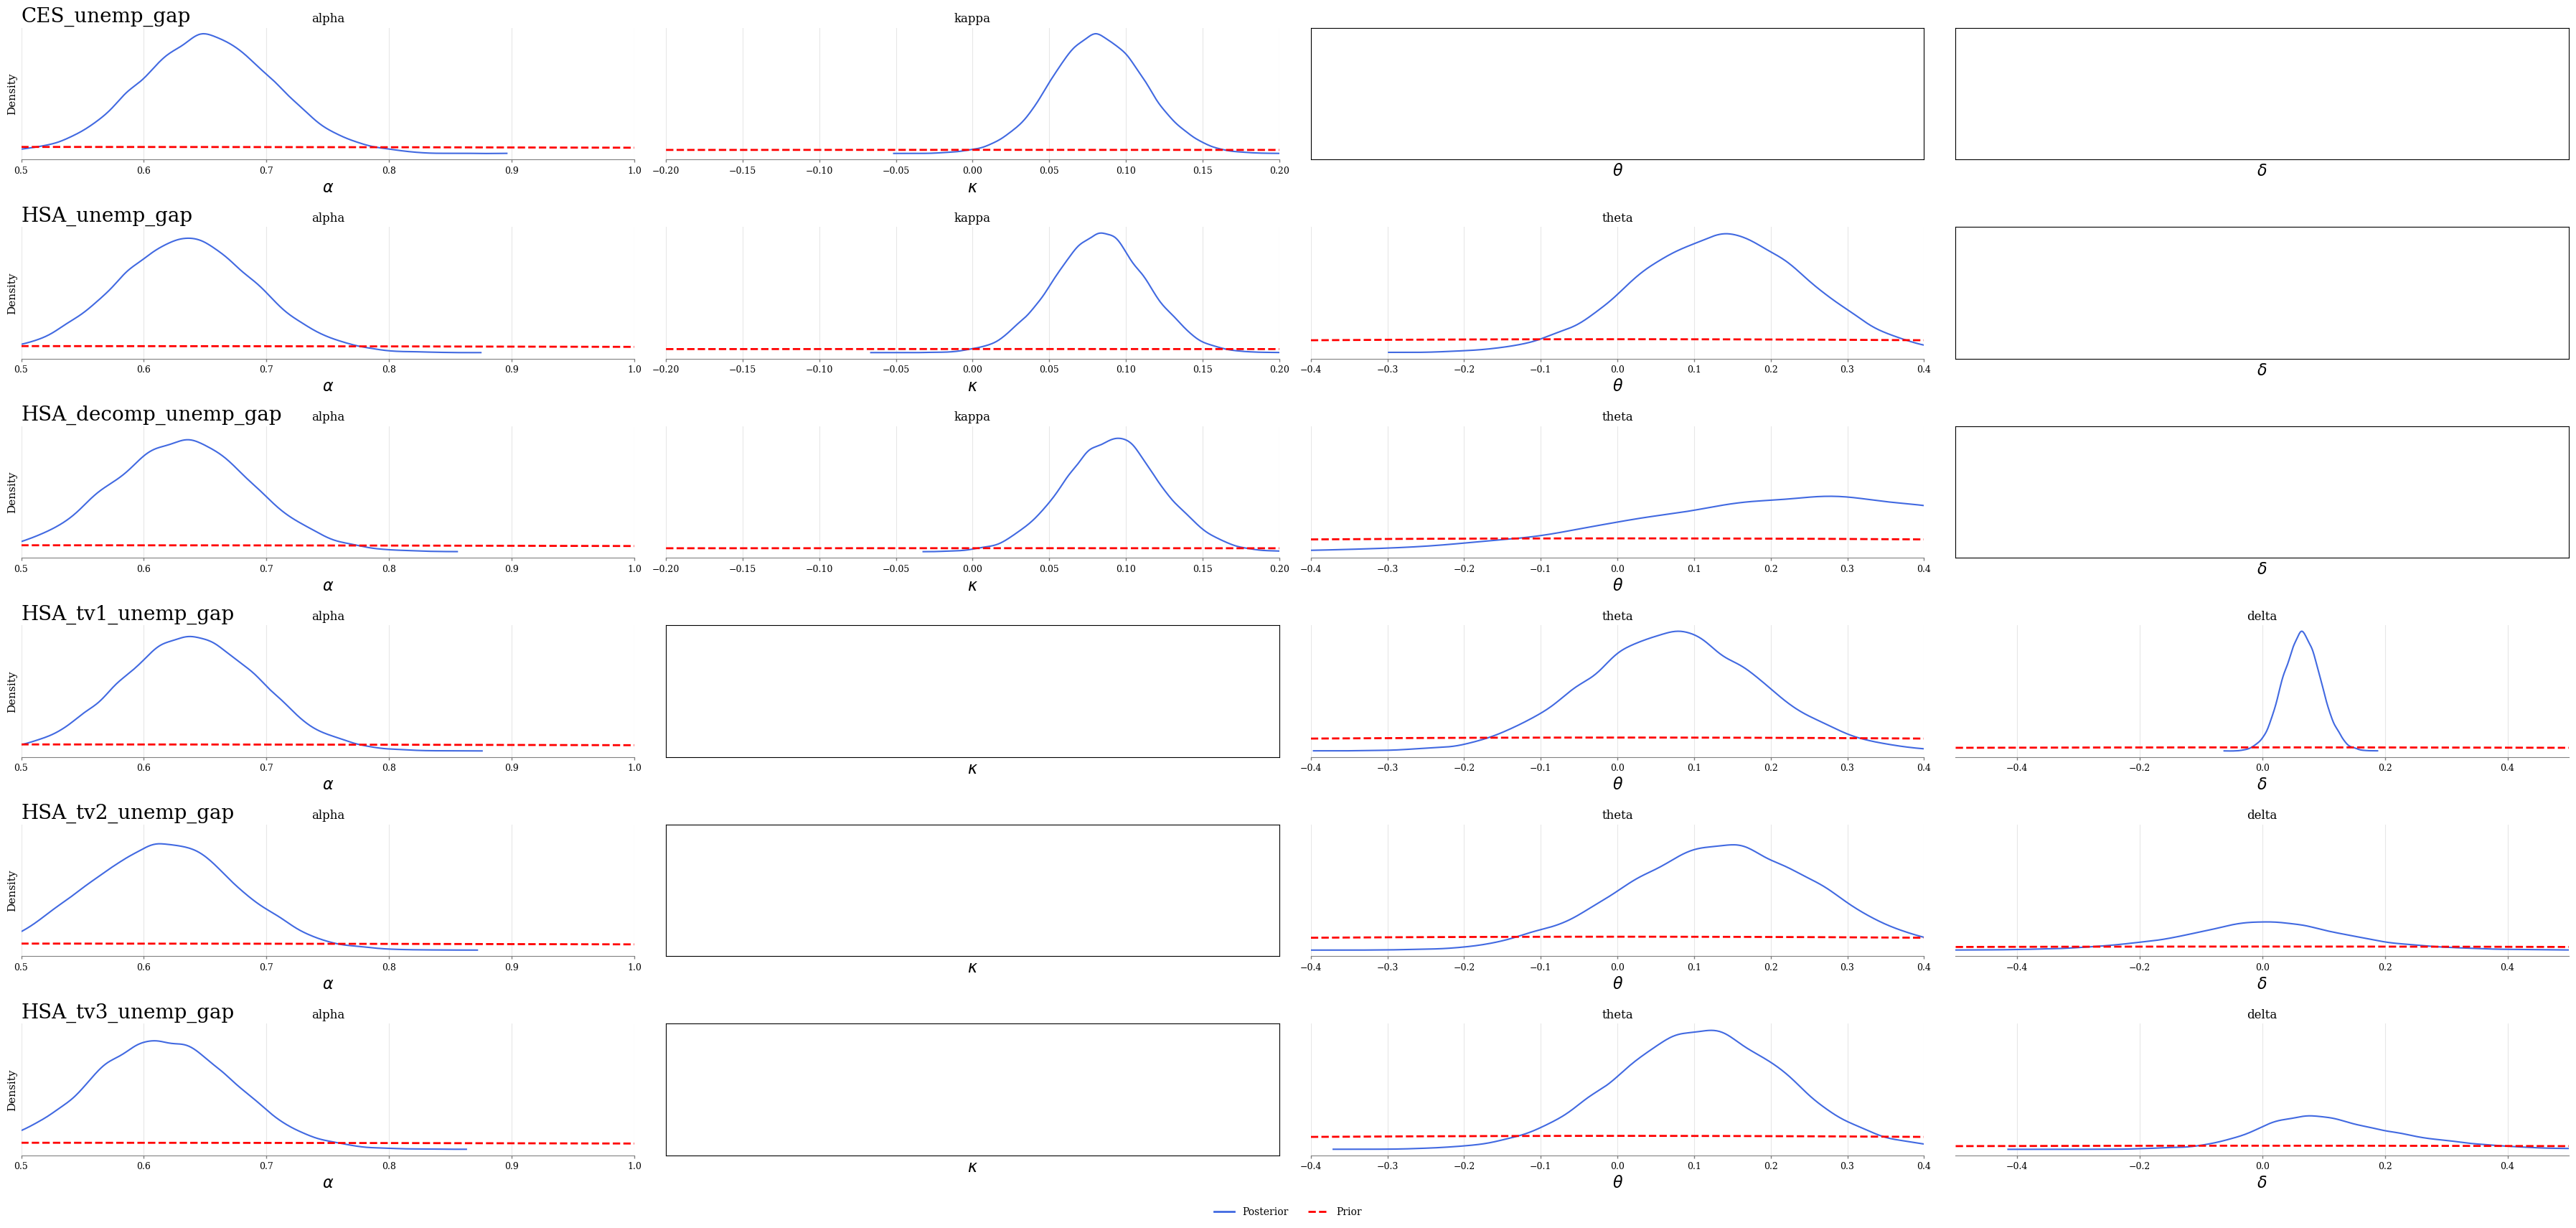

Model 'CES_unemp_gap' does not contain 'kappa_t' in posterior
Model 'HSA_unemp_gap' does not contain 'kappa_t' in posterior
Model 'HSA_decomp_unemp_gap' does not contain 'kappa_t' in posterior


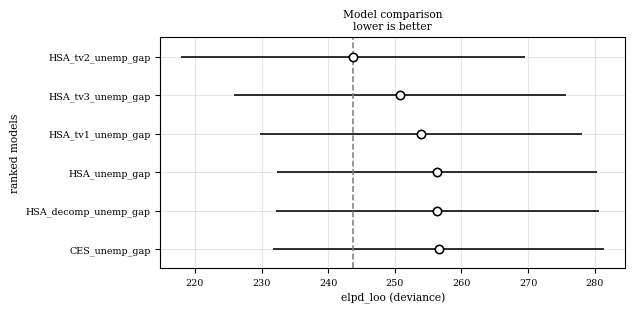

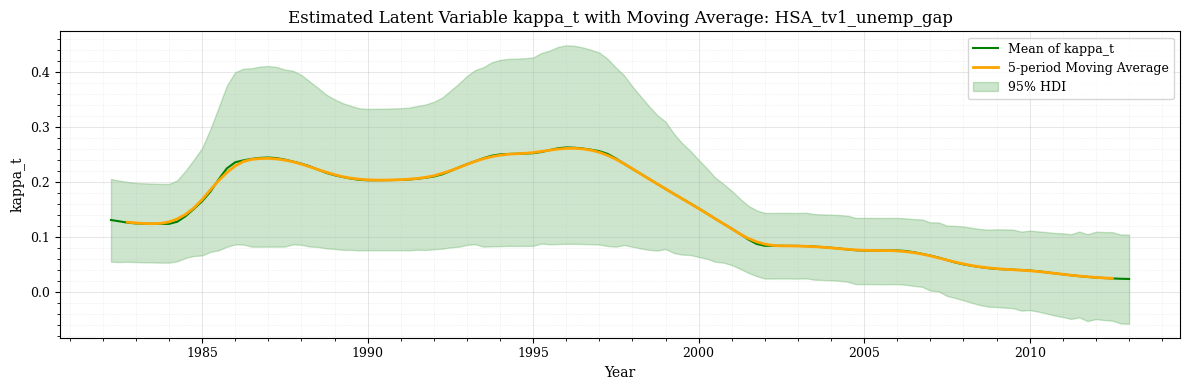

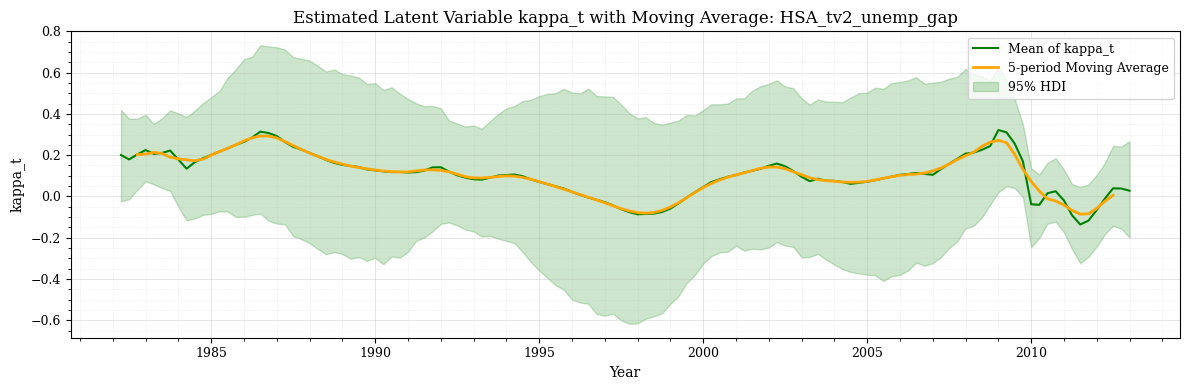

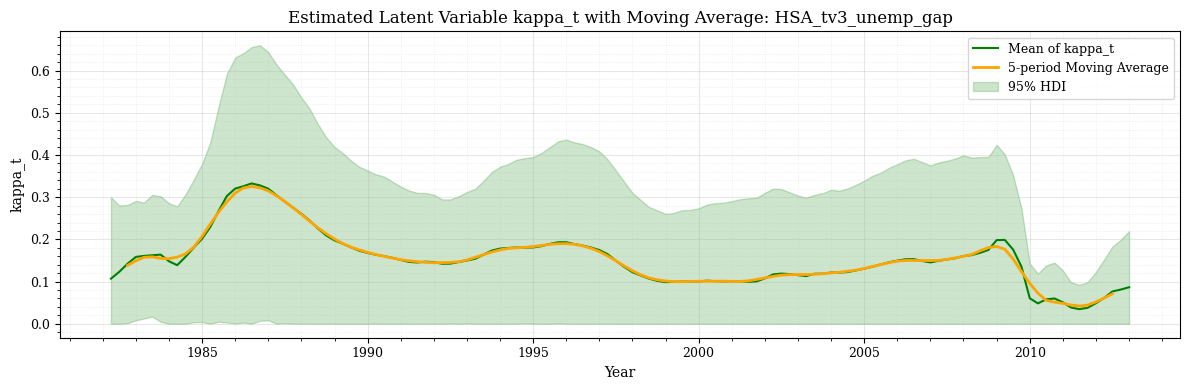

In [52]:
models_to_show = [
    "CES_unemp_gap", 
    "HSA_unemp_gap",
    "HSA_decomp_unemp_gap", 
    "HSA_tv1_unemp_gap", 
    "HSA_tv2_unemp_gap", 
    "HSA_tv3_unemp_gap",  
    "HSA_tv4_unemp_gap", 
    "HSA_tv5_unemp_gap", 
    "HSA_tv6_unemp_gap",
]
# dict_idata を subset
dict_items_fill = {k: v for k, v in dict_idata.items() if k in models_to_show}

def sddr_delta(idata):
    """BF_01 = posterior_density_at_0 / prior_density_at_0"""
    # posterior draws of kappa
    post = np.asarray(idata.posterior["delta"]).ravel()
    post = post[np.isfinite(post)]
    if post.size < 10:
        return np.nan  # safety

    # posterior density at 0 (KDE)
    kde = gaussian_kde(post)
    post_at0 = float(kde.evaluate([0.0])[0])
    # prior density at 0
    prior_at0 = norm.pdf(0.0, loc=delta_mu, scale=delta_sigma)
    return post_at0 / max(prior_at0, 1e-300)

show_hdi = False
target_params = ["alpha", "kappa", "theta", "delta"]
# ------- Summary table -------
summ_list = []
for model_name, idata in dict_items_fill.items():
    present = set(idata.posterior.data_vars)
    selected = list(present.intersection(target_params))
    if len(selected) == 0:
        continue
    # ArviZ summary
    s = az.summary(idata, var_names=selected, hdi_prob=0.95)
    s["param"] = s.index
    s["model"] = model_name
    s = s.reset_index(drop=True)
    s = s[["model", "param", "mean", "hdi_2.5%", "hdi_97.5%"]]
    summ_list.append(s)
summary_long = pd.concat(summ_list, ignore_index=True)

# ---- HDI on/off ----
if show_hdi:
    summary_long["value"] = summary_long.apply(
        lambda r: f"{r['mean']:.4f} [{r['hdi_2.5%']:.4f}, {r['hdi_97.5%']:.4f}]",
        axis=1
    )
else:
    summary_long["value"] = summary_long["mean"].map(lambda x: f"{x:.4f}")

# pivot
summary_wide = (
    summary_long.pivot_table(
        index="model",
        columns="param",
        values="value",
        aggfunc="first",
    )
    .reindex(columns=target_params)
    .reset_index()
    .rename_axis(None, axis=1)
)

display(HTML("<h3>Summary</h3>"))
display(summary_wide.style.hide(axis="index"))

# SDDR（kappa / theta）table
sddr_rows = []
for model_name, idata in dict_items_fill.items():
    try:
        bf01_kappa = sddr_kappa(idata)
    except Exception:
        bf01_kappa = np.nan
    try:
        bf01_theta = sddr_theta(idata)
    except Exception:
        bf01_theta = np.nan
    try:
        bf01_delta = sddr_delta(idata)
        df_sddr["SDDR_BF01_delta"] = bf01_delta
    except Exception:
        bf01_delta = np.nan
    sddr_rows.append({
        "model": model_name,
        "SDDR_BF01_kappa": bf01_kappa,
        "SDDR_BF01_theta": bf01_theta,
        "SDDR_BF01_delta": bf01_delta,
    })

df_sddr = pd.DataFrame(sddr_rows)
df_sddr["SDDR_BF01_kappa"] = df_sddr["SDDR_BF01_kappa"].map(lambda v: f"{v:.4}")
df_sddr["SDDR_BF01_theta"] = df_sddr["SDDR_BF01_theta"].map(lambda v: f"{v:.4}")
df_sddr["SDDR_BF01_delta"] = df_sddr["SDDR_BF01_delta"].map(lambda v: f"{v:.4}")


display(HTML("<h3>SDDR: kappa: Bayes Factor (BF01)</h3>"))
display(df_sddr.style.hide(axis="index"))

display(HTML("<h3>prior vs posterior </h3>"))
# 6) prior vs posterior 
params = ("alpha", "kappa", "theta", "delta")
try:
    idatas = [idata for _, idata in dict_items_fill.items()]
    labels  = [name for name, _ in dict_items_fill.items()]
    fig = plot_prior_posterior_grid(
            idatas=idatas,
            labels=labels,
            params=params,
            xlims={"kappa": (-0.2, 0.2), "alpha": (0.5, 1.0), "theta": (-0.4, 0.4), "delta": (-0.5, 0.5)})
    plt.show()
except Exception as e:
    print(f"[plot_prior_posterior_grid] error: {e}")


display(HTML("<h3>WAIC</h3>"))
df_waic = az.compare(dict_items_fill, var_name="pi_obs" ,ic='loo', scale='deviance')
az.plot_compare(df_waic, figsize=(6, 3))

# ===== New: Plot kappa_t for each model with 95% HDI =====
display(HTML("<h3>Latent Variable kappa_t (95% HDI) for Each Model</h3>"))
for model_name, idata in dict_items_fill.items():
    try:
        # Extract kappa_t samples from posterior
        if "kappa_t" in idata.posterior:
            kappa_samples = idata.posterior["kappa_t"].values
            # Flatten chain and draw dimensions: (chain, draw, time) -> (samples, time)
            kappa_samples = kappa_samples.reshape(-1, kappa_samples.shape[-1])
            
            # Calculate mean and 95% HDI using ArviZ
            kappa_mean = np.mean(kappa_samples, axis=0)
            kappa_hdi = az.hdi(kappa_samples, hdi_prob=0.95)
            kappa_lower = kappa_hdi[:, 0]
            kappa_upper = kappa_hdi[:, 1]
            
            # Moving average
            window = 5
            kappa_ma = pd.Series(kappa_mean).rolling(window=window, center=True).mean()
            
            # Plot
            plt.figure(figsize=(12, 4))
            plt.plot(data["DATE"], kappa_mean, label="Mean of kappa_t", color="green")
            plt.plot(data["DATE"], kappa_ma, label=f"{window}-period Moving Average", 
                    color="orange", linewidth=2)
            plt.fill_between(data["DATE"], kappa_lower, kappa_upper, 
                           color="green", alpha=0.2, label="95% HDI")
            
            plt.title(f"Estimated Latent Variable kappa_t with Moving Average: {model_name}")
            plt.xlabel("Year")
            plt.ylabel("kappa_t")
            plt.legend()
            plt.minorticks_on()
            plt.grid(which='major', linestyle='-', linewidth=0.75)
            plt.grid(which='minor', linestyle=':', linewidth=0.5)
            
            ax = plt.gca()
            ax.xaxis.set_major_locator(mdates.YearLocator(5))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            ax.xaxis.set_minor_locator(mdates.YearLocator(1))
            plt.tight_layout()
            plt.show()
        else:
            print(f"Model '{model_name}' does not contain 'kappa_t' in posterior")
            
    except Exception as e:
        print(f"[kappa_t plot] {model_name} error: {e}")

### Cycle of GDPC1

model,alpha,kappa,theta,delta
CES_output_gap,0.7070,0.0940,nan,nan
HSA_decomp_output_gap,0.6950,0.1000,0.2000,nan
HSA_output_gap,0.6900,0.1030,0.1680,nan
HSA_tv1_output_gap,0.6390,nan,0.2140,-0.1150
HSA_tv2_output_gap,0.6260,nan,0.3890,-0.0810
HSA_tv3_output_gap,0.6630,nan,0.2120,-0.0460


model,SDDR_BF01_kappa,SDDR_BF01_theta,SDDR_BF01_delta
CES_output_gap,2.114,nan,nan
HSA_output_gap,1.181,2.943,nan
HSA_decomp_output_gap,1.438,2.877,nan
HSA_tv1_output_gap,nan,1.343,0.3743
HSA_tv2_output_gap,nan,0.2895,3.918
HSA_tv3_output_gap,nan,1.569,6.318


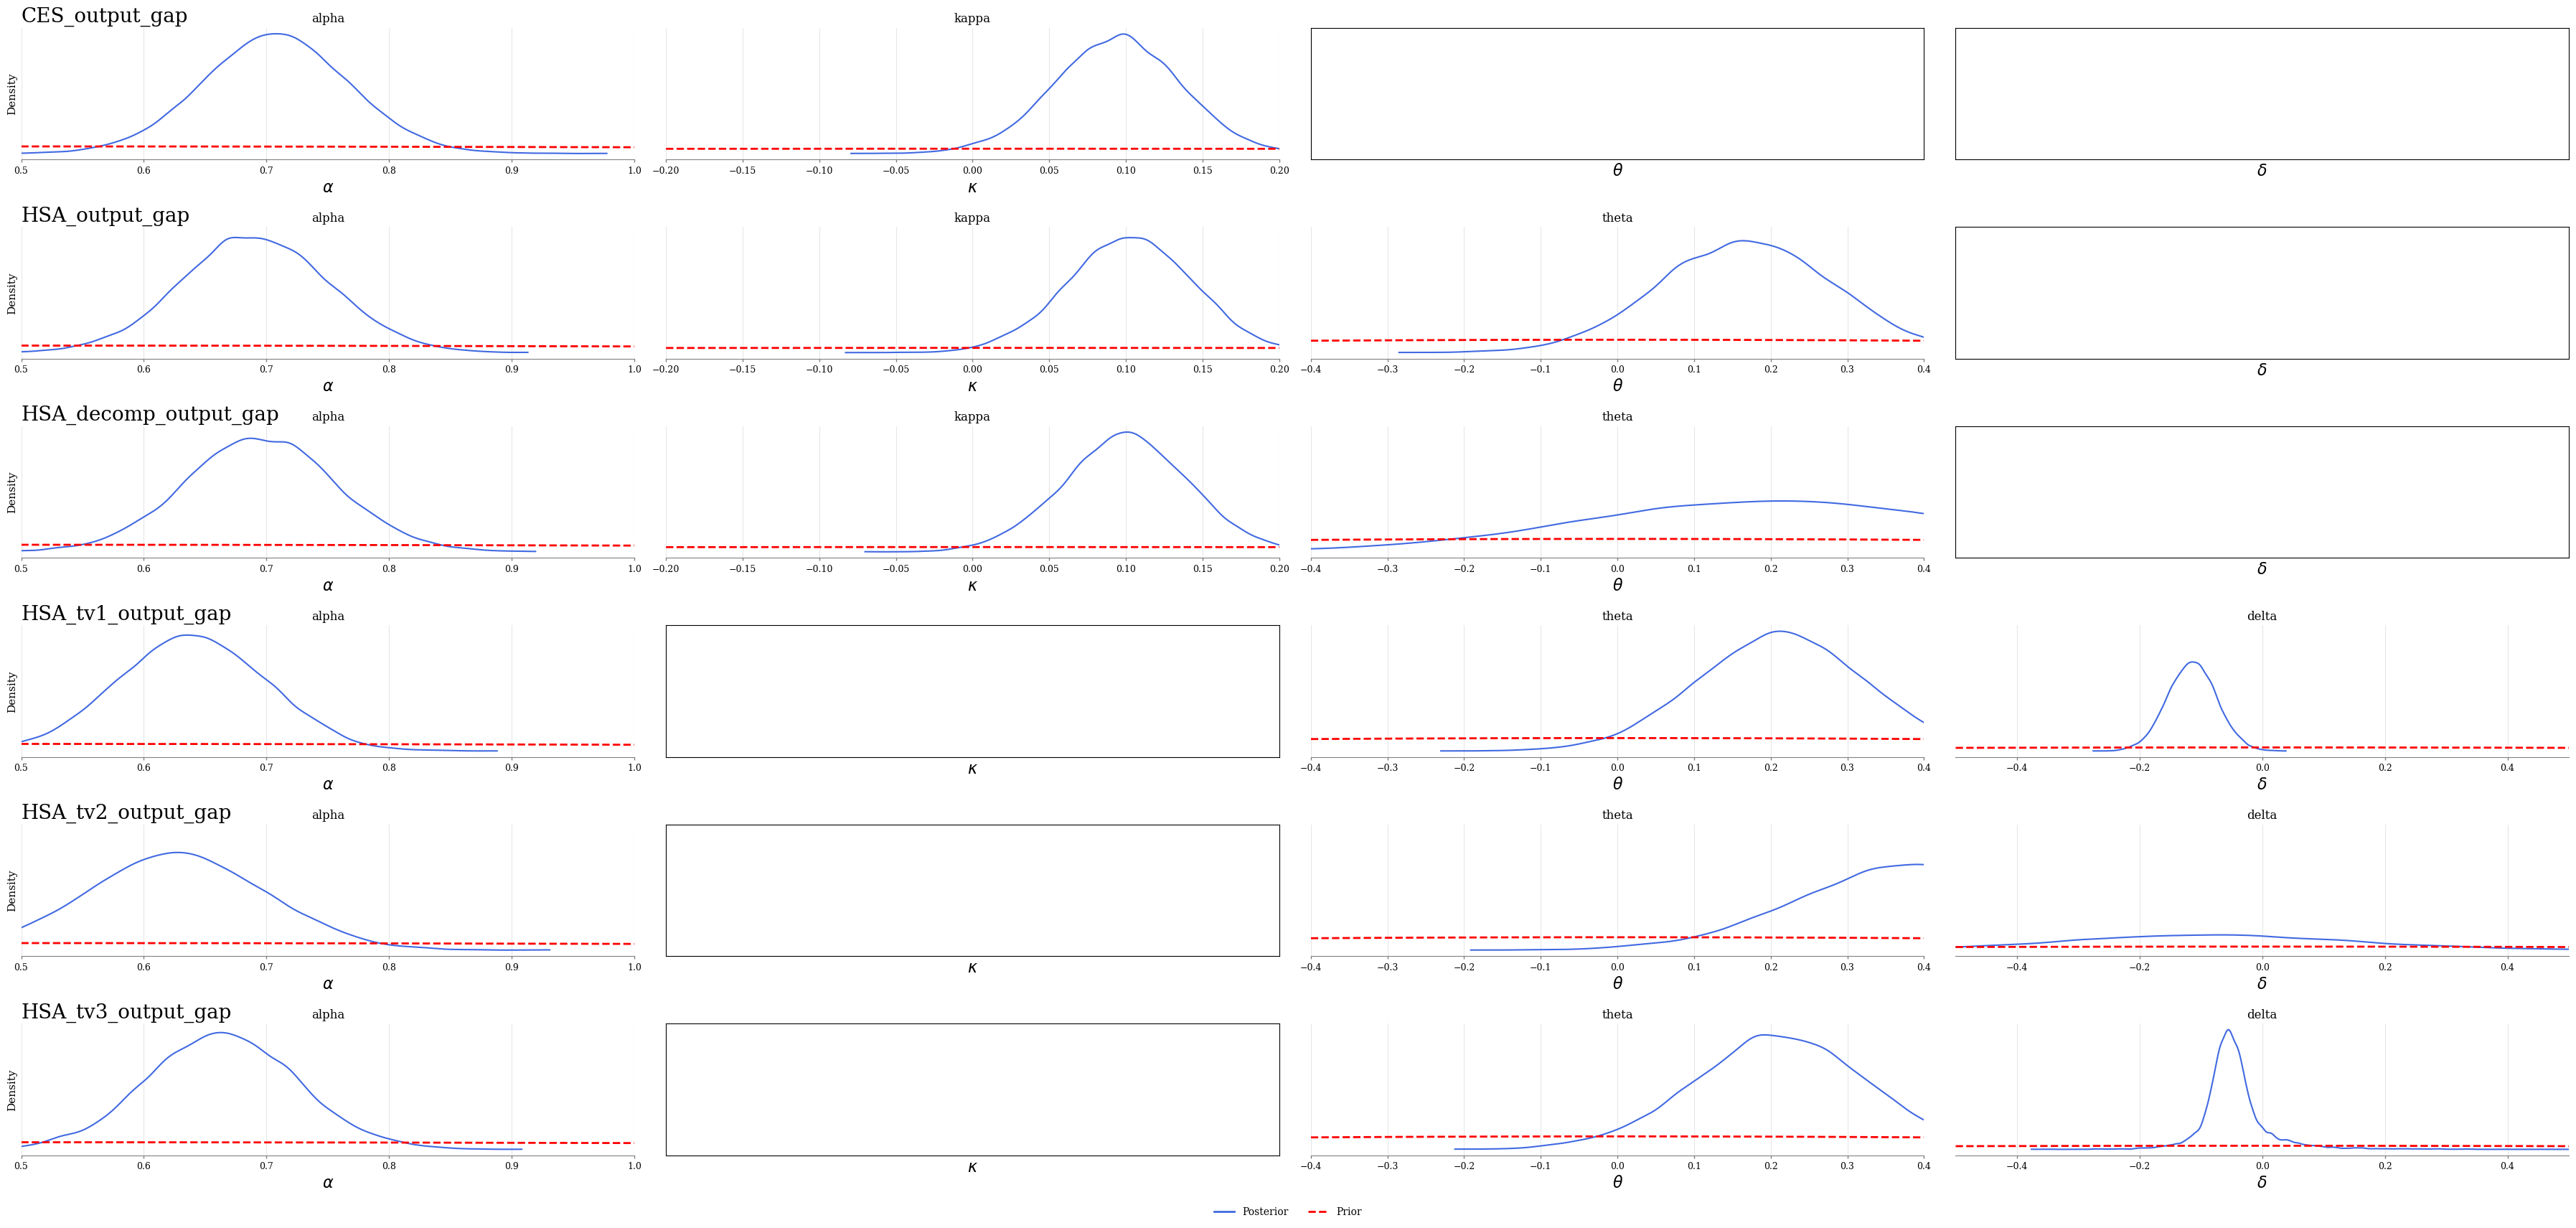

Model 'CES_output_gap' does not contain 'kappa_t' in posterior
Model 'HSA_output_gap' does not contain 'kappa_t' in posterior
Model 'HSA_decomp_output_gap' does not contain 'kappa_t' in posterior


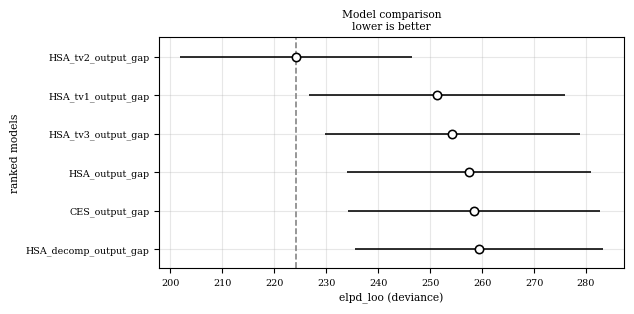

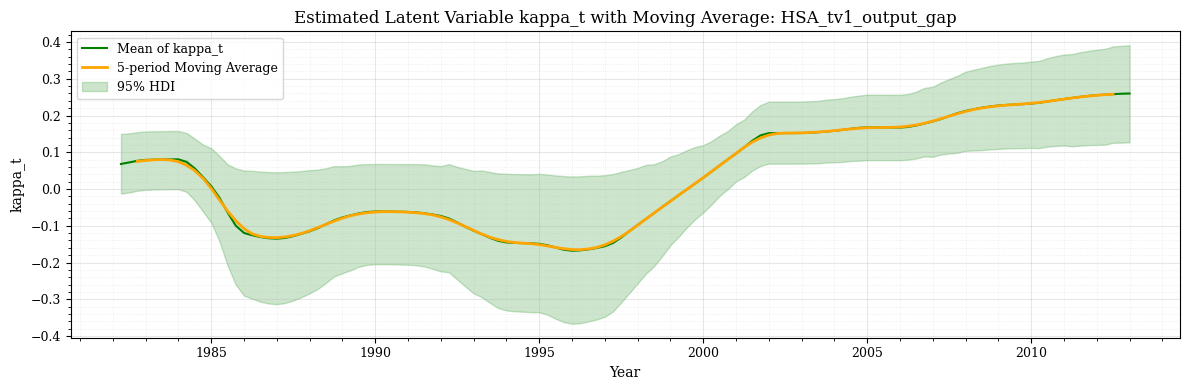

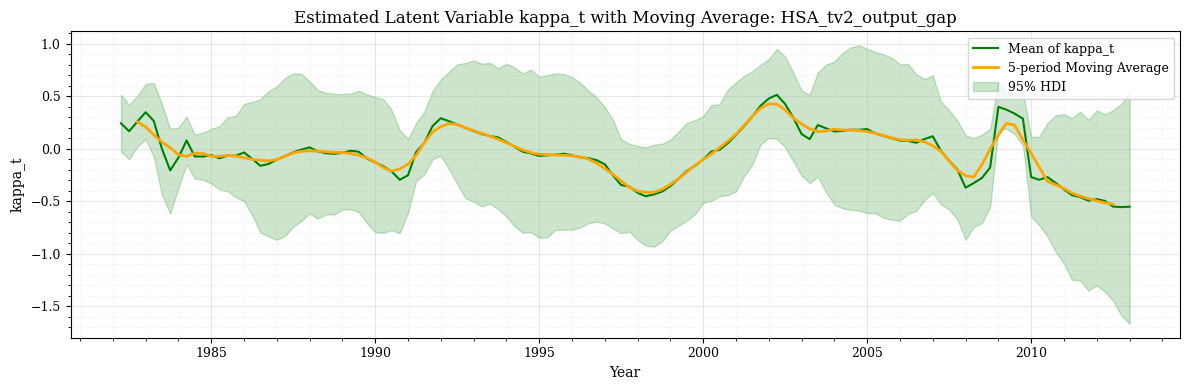

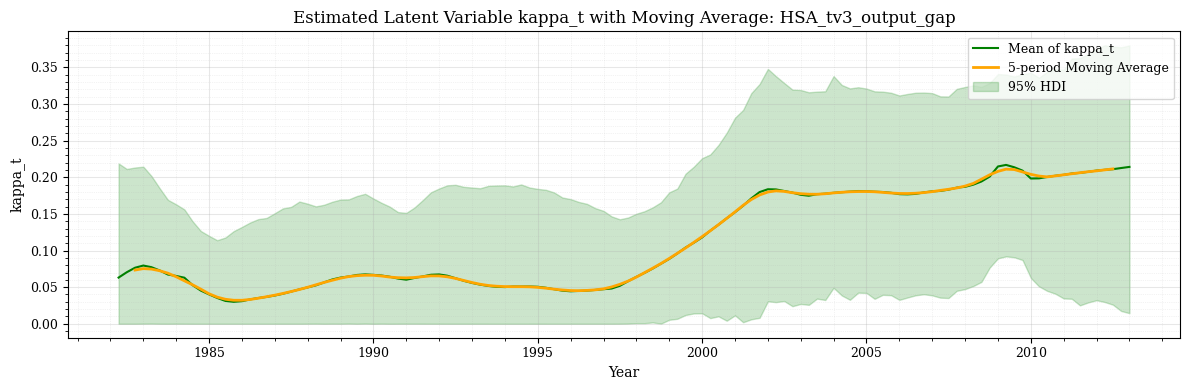

In [53]:
models_to_show = [
    "CES_output_gap", 
    "HSA_output_gap",
    "HSA_decomp_output_gap", 
    "HSA_tv1_output_gap", 
    "HSA_tv2_output_gap", 
    "HSA_tv3_output_gap",  
]
# dict_idata を subset
dict_items_fill = {k: v for k, v in dict_idata.items() if k in models_to_show}

def sddr_delta(idata):
    """BF_01 = posterior_density_at_0 / prior_density_at_0"""
    # posterior draws of kappa
    post = np.asarray(idata.posterior["delta"]).ravel()
    post = post[np.isfinite(post)]
    if post.size < 10:
        return np.nan  # safety

    # posterior density at 0 (KDE)
    kde = gaussian_kde(post)
    post_at0 = float(kde.evaluate([0.0])[0])
    # prior density at 0
    prior_at0 = norm.pdf(0.0, loc=delta_mu, scale=delta_sigma)
    return post_at0 / max(prior_at0, 1e-300)

show_hdi = False
target_params = ["alpha", "kappa", "theta", "delta"]
# ------- Summary table -------
summ_list = []
for model_name, idata in dict_items_fill.items():
    present = set(idata.posterior.data_vars)
    selected = list(present.intersection(target_params))
    if len(selected) == 0:
        continue
    # ArviZ summary
    s = az.summary(idata, var_names=selected, hdi_prob=0.95)
    s["param"] = s.index
    s["model"] = model_name
    s = s.reset_index(drop=True)
    s = s[["model", "param", "mean", "hdi_2.5%", "hdi_97.5%"]]
    summ_list.append(s)
summary_long = pd.concat(summ_list, ignore_index=True)

# ---- HDI on/off ----
if show_hdi:
    summary_long["value"] = summary_long.apply(
        lambda r: f"{r['mean']:.4f} [{r['hdi_2.5%']:.4f}, {r['hdi_97.5%']:.4f}]",
        axis=1
    )
else:
    summary_long["value"] = summary_long["mean"].map(lambda x: f"{x:.4f}")

# pivot
summary_wide = (
    summary_long.pivot_table(
        index="model",
        columns="param",
        values="value",
        aggfunc="first",
    )
    .reindex(columns=target_params)
    .reset_index()
    .rename_axis(None, axis=1)
)

display(HTML("<h3>Summary</h3>"))
display(summary_wide.style.hide(axis="index"))

# SDDR（kappa / theta）table
sddr_rows = []
for model_name, idata in dict_items_fill.items():
    try:
        bf01_kappa = sddr_kappa(idata)
    except Exception:
        bf01_kappa = np.nan
    try:
        bf01_theta = sddr_theta(idata)
    except Exception:
        bf01_theta = np.nan
    try:
        bf01_delta = sddr_delta(idata)
        df_sddr["SDDR_BF01_delta"] = bf01_delta
    except Exception:
        bf01_delta = np.nan
    sddr_rows.append({
        "model": model_name,
        "SDDR_BF01_kappa": bf01_kappa,
        "SDDR_BF01_theta": bf01_theta,
        "SDDR_BF01_delta": bf01_delta,
    })

df_sddr = pd.DataFrame(sddr_rows)
df_sddr["SDDR_BF01_kappa"] = df_sddr["SDDR_BF01_kappa"].map(lambda v: f"{v:.4}")
df_sddr["SDDR_BF01_theta"] = df_sddr["SDDR_BF01_theta"].map(lambda v: f"{v:.4}")
df_sddr["SDDR_BF01_delta"] = df_sddr["SDDR_BF01_delta"].map(lambda v: f"{v:.4}")


display(HTML("<h3>SDDR: kappa: Bayes Factor (BF01)</h3>"))
display(df_sddr.style.hide(axis="index"))

display(HTML("<h3>prior vs posterior </h3>"))
# 6) prior vs posterior 
params = ("alpha", "kappa", "theta", "delta")
try:
    idatas = [idata for _, idata in dict_items_fill.items()]
    labels  = [name for name, _ in dict_items_fill.items()]
    fig = plot_prior_posterior_grid(
            idatas=idatas,
            labels=labels,
            params=params,
            xlims={"kappa": (-0.2, 0.2), "alpha": (0.5, 1.0), "theta": (-0.4, 0.4), "delta": (-0.5, 0.5)})
    plt.show()
except Exception as e:
    print(f"[plot_prior_posterior_grid] error: {e}")


display(HTML("<h3>WAIC</h3>"))
df_waic = az.compare(dict_items_fill, var_name="pi_obs" ,ic='loo', scale='deviance')
az.plot_compare(df_waic, figsize=(6, 3))

# ===== New: Plot kappa_t for each model with 95% HDI =====
display(HTML("<h3>Latent Variable kappa_t (95% HDI) for Each Model</h3>"))
for model_name, idata in dict_items_fill.items():
    try:
        # Extract kappa_t samples from posterior
        if "kappa_t" in idata.posterior:
            kappa_samples = idata.posterior["kappa_t"].values
            # Flatten chain and draw dimensions: (chain, draw, time) -> (samples, time)
            kappa_samples = kappa_samples.reshape(-1, kappa_samples.shape[-1])
            
            # Calculate mean and 95% HDI using ArviZ
            kappa_mean = np.mean(kappa_samples, axis=0)
            kappa_hdi = az.hdi(kappa_samples, hdi_prob=0.95)
            kappa_lower = kappa_hdi[:, 0]
            kappa_upper = kappa_hdi[:, 1]
            
            # Moving average
            window = 5
            kappa_ma = pd.Series(kappa_mean).rolling(window=window, center=True).mean()
            
            # Plot
            plt.figure(figsize=(12, 4))
            plt.plot(data["DATE"], kappa_mean, label="Mean of kappa_t", color="green")
            plt.plot(data["DATE"], kappa_ma, label=f"{window}-period Moving Average", 
                    color="orange", linewidth=2)
            plt.fill_between(data["DATE"], kappa_lower, kappa_upper, 
                           color="green", alpha=0.2, label="95% HDI")
            
            plt.title(f"Estimated Latent Variable kappa_t with Moving Average: {model_name}")
            plt.xlabel("Year")
            plt.ylabel("kappa_t")
            plt.legend()
            plt.minorticks_on()
            plt.grid(which='major', linestyle='-', linewidth=0.75)
            plt.grid(which='minor', linestyle=':', linewidth=0.5)
            
            ax = plt.gca()
            ax.xaxis.set_major_locator(mdates.YearLocator(5))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            ax.xaxis.set_minor_locator(mdates.YearLocator(1))
            plt.tight_layout()
            plt.show()
        else:
            print(f"Model '{model_name}' does not contain 'kappa_t' in posterior")
            
    except Exception as e:
        print(f"[kappa_t plot] {model_name} error: {e}")

### Inv of Markup (BN)

model,alpha,kappa,theta,delta
CES_markup_BN,0.6650,-0.0130,nan,nan
HSA_decomp_markup_BN,0.6540,0.0030,0.1200,nan
HSA_markup_BN,0.6470,0.0040,0.1280,nan
HSA_tv1_markup_BN,0.6360,nan,0.1420,-0.0620
HSA_tv2_markup_BN,0.6220,nan,0.1450,-0.1370
HSA_tv3_markup_BN,0.6400,nan,0.1480,0.0310


model,SDDR_BF01_kappa,SDDR_BF01_theta,SDDR_BF01_delta
CES_markup_BN,10.28,nan,nan
HSA_markup_BN,10.18,4.721,nan
HSA_decomp_markup_BN,9.844,3.418,nan
HSA_tv1_markup_BN,nan,3.992,8.876
HSA_tv2_markup_BN,nan,3.92,5.706
HSA_tv3_markup_BN,nan,3.677,12.73


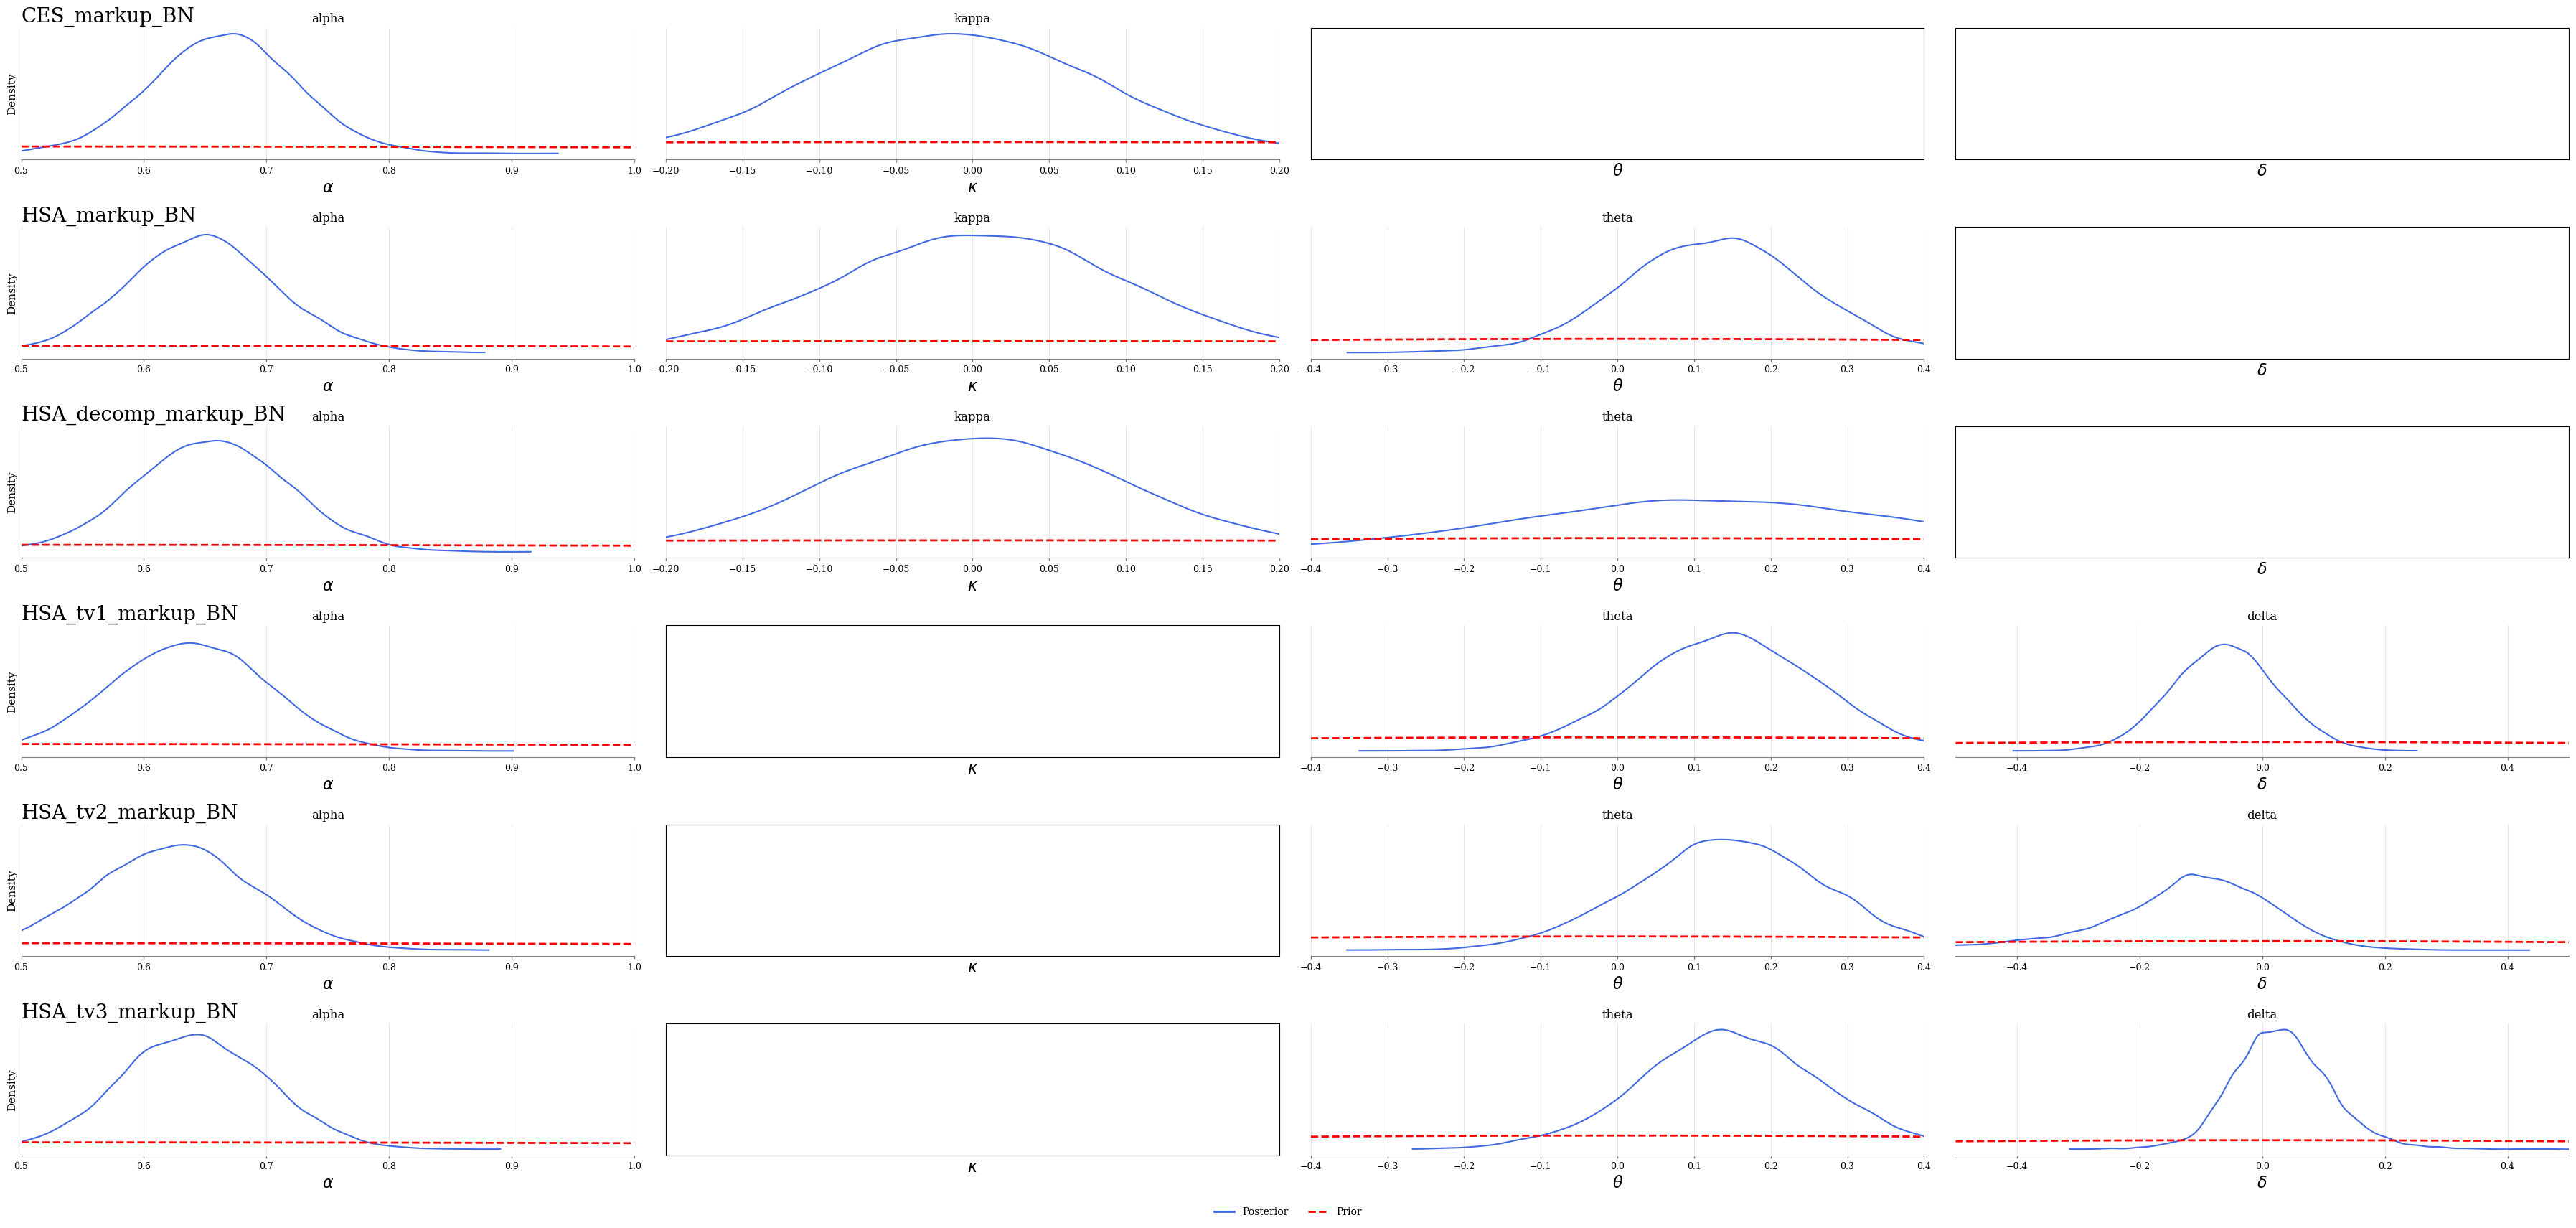

Model 'CES_markup_BN' does not contain 'kappa_t' in posterior
Model 'HSA_markup_BN' does not contain 'kappa_t' in posterior
Model 'HSA_decomp_markup_BN' does not contain 'kappa_t' in posterior


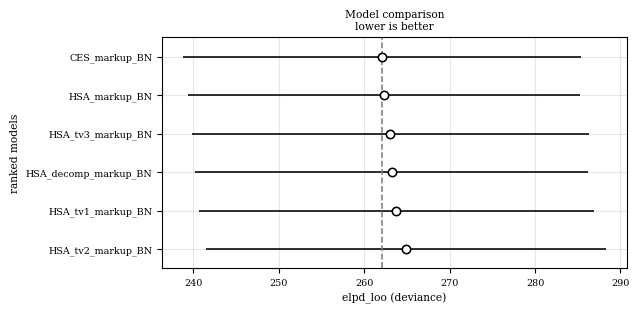

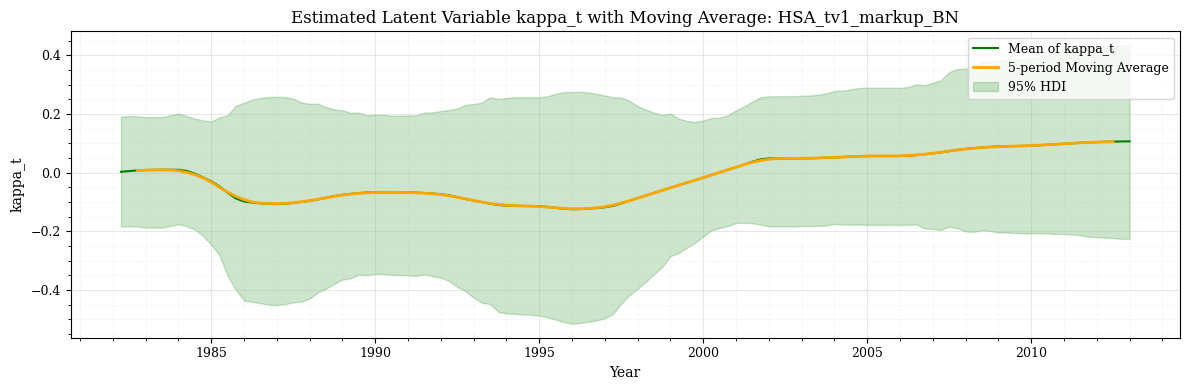

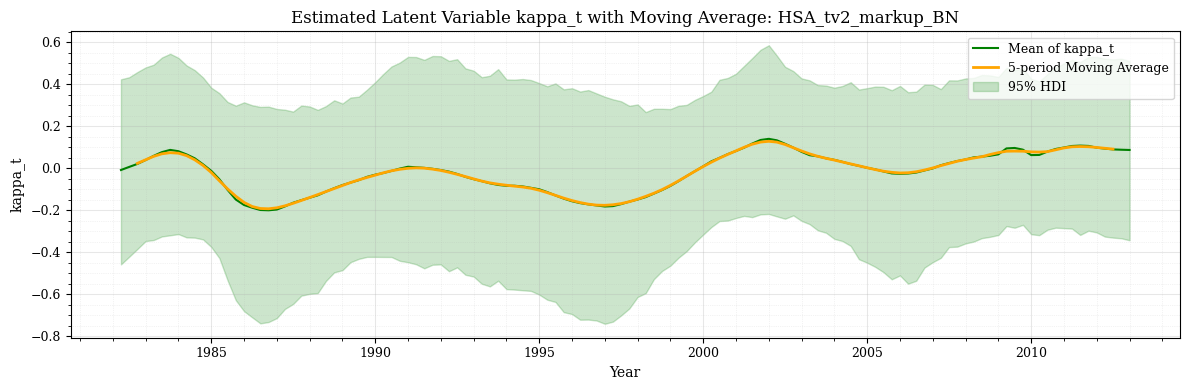

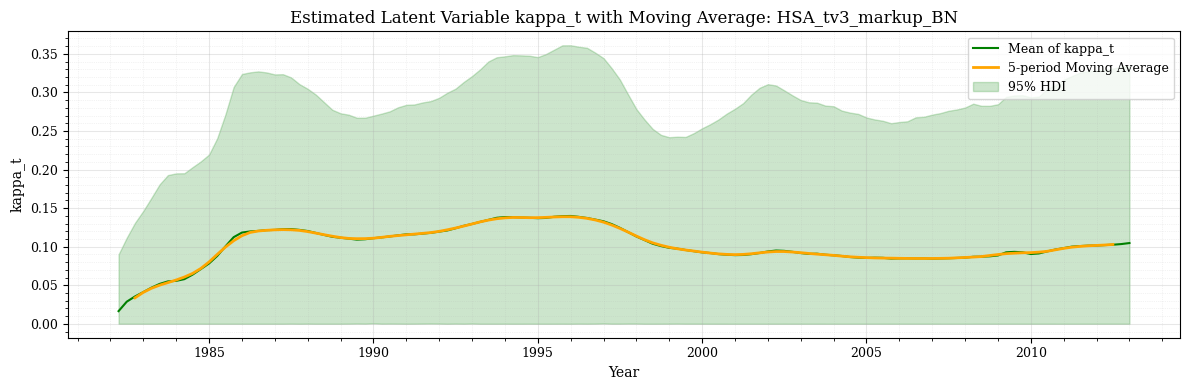

In [54]:
models_to_show = [
    "CES_markup_BN", 
    "HSA_markup_BN",
    "HSA_decomp_markup_BN", 
    "HSA_tv1_markup_BN", 
    "HSA_tv2_markup_BN", 
    "HSA_tv3_markup_BN",  
]
# dict_idata を subset
dict_items_fill = {k: v for k, v in dict_idata.items() if k in models_to_show}

def sddr_delta(idata):
    """BF_01 = posterior_density_at_0 / prior_density_at_0"""
    # posterior draws of kappa
    post = np.asarray(idata.posterior["delta"]).ravel()
    post = post[np.isfinite(post)]
    if post.size < 10:
        return np.nan  # safety

    # posterior density at 0 (KDE)
    kde = gaussian_kde(post)
    post_at0 = float(kde.evaluate([0.0])[0])
    # prior density at 0
    prior_at0 = norm.pdf(0.0, loc=delta_mu, scale=delta_sigma)
    return post_at0 / max(prior_at0, 1e-300)

show_hdi = False
target_params = ["alpha", "kappa", "theta", "delta"]
# ------- Summary table -------
summ_list = []
for model_name, idata in dict_items_fill.items():
    present = set(idata.posterior.data_vars)
    selected = list(present.intersection(target_params))
    if len(selected) == 0:
        continue
    # ArviZ summary
    s = az.summary(idata, var_names=selected, hdi_prob=0.95)
    s["param"] = s.index
    s["model"] = model_name
    s = s.reset_index(drop=True)
    s = s[["model", "param", "mean", "hdi_2.5%", "hdi_97.5%"]]
    summ_list.append(s)
summary_long = pd.concat(summ_list, ignore_index=True)

# ---- HDI on/off ----
if show_hdi:
    summary_long["value"] = summary_long.apply(
        lambda r: f"{r['mean']:.4f} [{r['hdi_2.5%']:.4f}, {r['hdi_97.5%']:.4f}]",
        axis=1
    )
else:
    summary_long["value"] = summary_long["mean"].map(lambda x: f"{x:.4f}")

# pivot
summary_wide = (
    summary_long.pivot_table(
        index="model",
        columns="param",
        values="value",
        aggfunc="first",
    )
    .reindex(columns=target_params)
    .reset_index()
    .rename_axis(None, axis=1)
)

display(HTML("<h3>Summary</h3>"))
display(summary_wide.style.hide(axis="index"))

# SDDR（kappa / theta）table
sddr_rows = []
for model_name, idata in dict_items_fill.items():
    try:
        bf01_kappa = sddr_kappa(idata)
    except Exception:
        bf01_kappa = np.nan
    try:
        bf01_theta = sddr_theta(idata)
    except Exception:
        bf01_theta = np.nan
    try:
        bf01_delta = sddr_delta(idata)
        df_sddr["SDDR_BF01_delta"] = bf01_delta
    except Exception:
        bf01_delta = np.nan
    sddr_rows.append({
        "model": model_name,
        "SDDR_BF01_kappa": bf01_kappa,
        "SDDR_BF01_theta": bf01_theta,
        "SDDR_BF01_delta": bf01_delta,
    })

df_sddr = pd.DataFrame(sddr_rows)
df_sddr["SDDR_BF01_kappa"] = df_sddr["SDDR_BF01_kappa"].map(lambda v: f"{v:.4}")
df_sddr["SDDR_BF01_theta"] = df_sddr["SDDR_BF01_theta"].map(lambda v: f"{v:.4}")
df_sddr["SDDR_BF01_delta"] = df_sddr["SDDR_BF01_delta"].map(lambda v: f"{v:.4}")


display(HTML("<h3>SDDR: kappa: Bayes Factor (BF01)</h3>"))
display(df_sddr.style.hide(axis="index"))

display(HTML("<h3>prior vs posterior </h3>"))
# 6) prior vs posterior 
params = ("alpha", "kappa", "theta", "delta")
try:
    idatas = [idata for _, idata in dict_items_fill.items()]
    labels  = [name for name, _ in dict_items_fill.items()]
    fig = plot_prior_posterior_grid(
            idatas=idatas,
            labels=labels,
            params=params,
            xlims={"kappa": (-0.2, 0.2), "alpha": (0.5, 1.0), "theta": (-0.4, 0.4), "delta": (-0.5, 0.5)})
    plt.show()
except Exception as e:
    print(f"[plot_prior_posterior_grid] error: {e}")


display(HTML("<h3>WAIC</h3>"))
df_waic = az.compare(dict_items_fill, var_name="pi_obs" ,ic='loo', scale='deviance')
az.plot_compare(df_waic, figsize=(6, 3))

# ===== New: Plot kappa_t for each model with 95% HDI =====
display(HTML("<h3>Latent Variable kappa_t (95% HDI) for Each Model</h3>"))
for model_name, idata in dict_items_fill.items():
    try:
        # Extract kappa_t samples from posterior
        if "kappa_t" in idata.posterior:
            kappa_samples = idata.posterior["kappa_t"].values
            # Flatten chain and draw dimensions: (chain, draw, time) -> (samples, time)
            kappa_samples = kappa_samples.reshape(-1, kappa_samples.shape[-1])
            
            # Calculate mean and 95% HDI using ArviZ
            kappa_mean = np.mean(kappa_samples, axis=0)
            kappa_hdi = az.hdi(kappa_samples, hdi_prob=0.95)
            kappa_lower = kappa_hdi[:, 0]
            kappa_upper = kappa_hdi[:, 1]
            
            # Moving average
            window = 5
            kappa_ma = pd.Series(kappa_mean).rolling(window=window, center=True).mean()
            
            # Plot
            plt.figure(figsize=(12, 4))
            plt.plot(data["DATE"], kappa_mean, label="Mean of kappa_t", color="green")
            plt.plot(data["DATE"], kappa_ma, label=f"{window}-period Moving Average", 
                    color="orange", linewidth=2)
            plt.fill_between(data["DATE"], kappa_lower, kappa_upper, 
                           color="green", alpha=0.2, label="95% HDI")
            
            plt.title(f"Estimated Latent Variable kappa_t with Moving Average: {model_name}")
            plt.xlabel("Year")
            plt.ylabel("kappa_t")
            plt.legend()
            plt.minorticks_on()
            plt.grid(which='major', linestyle='-', linewidth=0.75)
            plt.grid(which='minor', linestyle=':', linewidth=0.5)
            
            ax = plt.gca()
            ax.xaxis.set_major_locator(mdates.YearLocator(5))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            ax.xaxis.set_minor_locator(mdates.YearLocator(1))
            plt.tight_layout()
            plt.show()
        else:
            print(f"Model '{model_name}' does not contain 'kappa_t' in posterior")
            
    except Exception as e:
        print(f"[kappa_t plot] {model_name} error: {e}")

=== Sign Consistency Check ===
Output gap mean: -0.1890
Empgap mean: -0.9883
Markup_inv mean: -0.0656
Correlation (output_gap, empgap): 0.3308
Correlation (output_gap, markup_inv): 0.0173

=== Relationship with Inflation ===
Inflation vs Output gap: r = 0.0686
Inflation vs Empgap: r = 0.1602
Inflation vs Markup_inv: r = 0.1453

=== Relationship with dNbar ===
dNbar → Output gap: slope=8.2709, r=0.2686
dNbar → Empgap: slope=-3.9506, r=-0.1191
dNbar → Markup_inv: slope=0.9892, r=0.0758


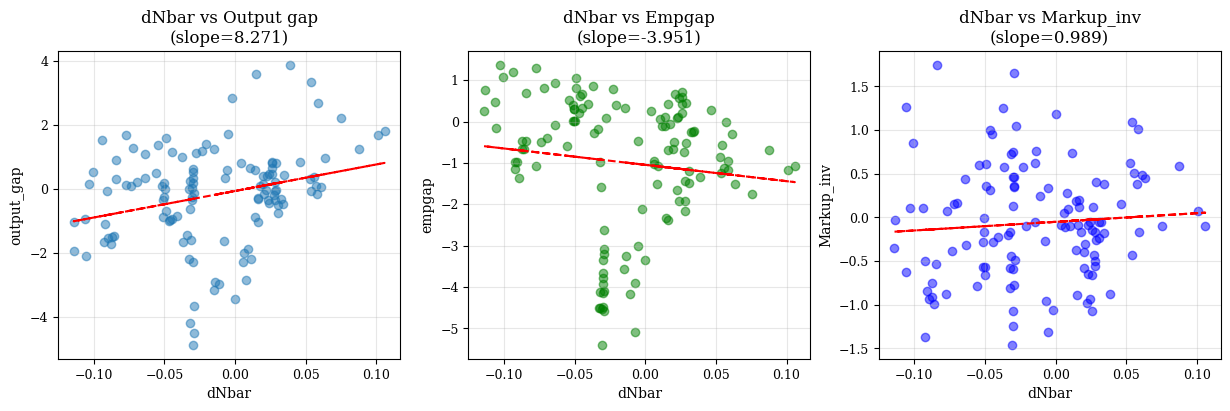

In [55]:
display(HTML("<h3>Why does delta flip sign between output_gap and empgap?</h3>"))

dNbar = np.concatenate([np.array([0.0]), np.diff(Nbar)])
empgap = x_unempgap
output_gap = x_output_gap
markup_inv = x_markup_bn
pi = pi
print("=== Sign Consistency Check ===")
print(f"Output gap mean: {output_gap.mean():.4f}")
print(f"Empgap mean: {empgap.mean():.4f}")
print(f"Markup_inv mean: {markup_inv.mean():.4f}")
print(f"Correlation (output_gap, empgap): {np.corrcoef(output_gap, empgap)[0,1]:.4f}")
print(f"Correlation (output_gap, markup_inv): {np.corrcoef(output_gap, markup_inv)[0,1]:.4f}")

print("\n=== Relationship with Inflation ===")
corr_pi_output = np.corrcoef(output_gap, pi)[0,1]
corr_pi_emp = np.corrcoef(empgap, pi)[0,1]
corr_pi_markup = np.corrcoef(markup_inv, pi)[0,1]
print(f"Inflation vs Output gap: r = {corr_pi_output:.4f}")
print(f"Inflation vs Empgap: r = {corr_pi_emp:.4f}")
print(f"Inflation vs Markup_inv: r = {corr_pi_markup:.4f}")

print("\n=== Relationship with dNbar ===")
from scipy.stats import linregress
slope_out, _, r_out, _, _ = linregress(dNbar, output_gap)
slope_emp, _, r_emp, _, _ = linregress(dNbar, empgap)
slope_markup, _, r_markup, _, _ = linregress(dNbar, markup_inv)

print(f"dNbar → Output gap: slope={slope_out:.4f}, r={r_out:.4f}")
print(f"dNbar → Empgap: slope={slope_emp:.4f}, r={r_emp:.4f}")
print(f"dNbar → Markup_inv: slope={slope_markup:.4f}, r={r_markup:.4f}")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].scatter(dNbar, output_gap, alpha=0.5)
axes[0].plot(dNbar, slope_out*dNbar + linregress(dNbar, output_gap)[1], 'r--')
axes[0].set_xlabel('dNbar')
axes[0].set_ylabel('output_gap')
axes[0].set_title(f'dNbar vs Output gap\n(slope={slope_out:.3f})')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(dNbar, empgap, alpha=0.5, color='green')
axes[1].plot(dNbar, slope_emp*dNbar + linregress(dNbar, empgap)[1], 'r--')
axes[1].set_xlabel('dNbar')
axes[1].set_ylabel('empgap')
axes[1].set_title(f'dNbar vs Empgap\n(slope={slope_emp:.3f})')
axes[1].grid(True, alpha=0.3)

axes[2].scatter(dNbar, markup_inv, alpha=0.5, color='blue')
axes[2].plot(dNbar, slope_markup*dNbar + linregress(dNbar, markup_inv)[1], 'r--')
axes[2].set_xlabel('dNbar')
axes[2].set_ylabel('Markup_inv')
axes[2].set_title(f'dNbar vs Markup_inv\n(slope={slope_markup:.3f})')
axes[2].grid(True, alpha=0.3)

plt.show()

# Time-variant kappa, joint decomposition

In [ ]:
def model_3_case1(pi, pi_prev, pi_expect, x, N, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    theta = numpyro.sample("theta", priors["theta"])
    delta = numpyro.sample("delta", priors["delta"])
    # State equation (N) params
    r = numpyro.sample("r", dist.Uniform(-1,1))      
    p = numpyro.sample("p", dist.Uniform(0.1, 0.9))  
    rho_1 = 2 * r * jnp.cos(jnp.pi * p)
    rho_2 = -r ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    n = numpyro.sample("n", priors["n"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_u  = numpyro.sample("sigma_u", priors["sigma_u"])      
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) 
    # initial 
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1))   # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, .05))    # Nhat init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, .05))    # Nhat init
    kappa0 = numpyro.sample("kappa0", priors["kappa"])   # kappa init
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        kappa_prev = carry[3]
        t = carry[4]
        # state equation
        # trend 
        Nbar_t = numpyro.sample("Nbar", dist.Normal(n + Nbar_prev, sigma_eps))
        # N (Nbar + Nhat = observed N)
        N_hat_obs = N[t] - Nbar_t
        # cycle
        N_hat_pred = rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2
        Nhat_t = numpyro.sample("Nhat_t", dist.Normal(N_hat_pred, sigma_u), obs=N_hat_obs)
        numpyro.deterministic("Nhat", Nhat_t) 
        # kappa
        kappa_t = kappa_prev + delta *(Nbar_t - Nbar_prev)
        numpyro.deterministic("kappa_t", kappa_t)    
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat_t
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat_t, Nhat_prev_1, kappa_t, t], None
    scan(transition, [bar_N_0, hat_N_0, hat_N_1, kappa0, t], timesteps)

def model_3_case2(pi, pi_prev, pi_expect, x, N, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    theta = numpyro.sample("theta", priors["theta"])
    delta = numpyro.sample("delta", priors["delta"])
    # State equation (N) params
    r = numpyro.sample("r", dist.Uniform(-1,1))      
    p = numpyro.sample("p", dist.Uniform(0.1, 0.9))  
    rho_1 = 2 * r * jnp.cos(jnp.pi * p)
    rho_2 = -r ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    n = numpyro.sample("n", priors["n"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_u  = numpyro.sample("sigma_u", priors["sigma_u"])      
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) 
    sigma_eta = numpyro.sample("sigma_eta", priors["sigma_eta"]) 
    # initial 
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1))   # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, .05))    # Nhat init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, .05))    # Nhat init
    kappa0 = numpyro.sample("kappa0", priors["kappa"])   # kappa init
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        kappa_prev = carry[3]
        t = carry[4]
        # state equation
        # trend 
        Nbar_t = numpyro.sample("Nbar", dist.Normal(n + Nbar_prev, sigma_eps))
        # N (Nbar + Nhat = observed N)
        N_hat_obs = N[t] - Nbar_t
        # cycle
        N_hat_pred = rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2
        Nhat_t = numpyro.sample("Nhat_t", dist.Normal(N_hat_pred, sigma_u), obs=N_hat_obs)
        numpyro.deterministic("Nhat", Nhat_t) 
        # kappa
        kappa_mu = kappa_prev + delta *(Nbar_t - Nbar_prev)
        kappa_t = numpyro.sample("kappa_t", dist.Normal(kappa_mu, sigma_eta))
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat_t
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat_t, Nhat_prev_1, kappa_t, t], None
    scan(transition, [bar_N_0, hat_N_0, hat_N_1, kappa0, t], timesteps)

### case 1

In [ ]:
# 1) model
dict_idata = {}
div_rows = []  # divergence 
print("=== Run models ===")
for model_name, x in x_dict.items():
    print(f"Running NKPC model: {model_name}")
    kernel = NUTS(model_3_case1, target_accept_prob=0.995)
    mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
    mcmc.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, N=N, l=len(pi))
    idata = az.from_numpyro(mcmc)
    dict_idata[model_name] = idata
    # Divergence diagnostics
    diverging = idata.sample_stats["diverging"].values
    ratio_div = float(np.mean(diverging))
    div_rows.append({"model": model_name, "divergence_ratio": ratio_div})
print("\n=== All models finished ===\n")

In [ ]:
def sddr_delta(idata):
    """BF_01 = posterior_density_at_0 / prior_density_at_0"""
    # posterior draws of kappa
    post = np.asarray(idata.posterior["delta"]).ravel()
    post = post[np.isfinite(post)]
    if post.size < 10:
        return np.nan  # safety

    # posterior density at 0 (KDE)
    kde = gaussian_kde(post)
    post_at0 = float(kde.evaluate([0.0])[0])
    # prior density at 0
    prior_at0 = norm.pdf(0.0, loc=delta_mu, scale=delta_sigma)
    return post_at0 / max(prior_at0, 1e-300)

show_hdi = False
target_params = ["alpha", "kappa", "theta", "delta", "beta"]
# ------- Summary table -------
summ_list = []
for model_name, idata in dict_idata.items():
    present = set(idata.posterior.data_vars)
    selected = list(present.intersection(target_params))
    if len(selected) == 0:
        continue
    # ArviZ summary
    s = az.summary(idata, var_names=selected, hdi_prob=0.95)
    s["param"] = s.index
    s["model"] = model_name
    s = s.reset_index(drop=True)
    s = s[["model", "param", "mean", "hdi_2.5%", "hdi_97.5%"]]
    summ_list.append(s)
summary_long = pd.concat(summ_list, ignore_index=True)

# ---- HDI on/off ----
if show_hdi:
    summary_long["value"] = summary_long.apply(
        lambda r: f"{r['mean']:.4f} [{r['hdi_2.5%']:.4f}, {r['hdi_97.5%']:.4f}]",
        axis=1
    )
else:
    summary_long["value"] = summary_long["mean"].map(lambda x: f"{x:.4f}")

# pivot
summary_wide = (
    summary_long.pivot_table(
        index="model",
        columns="param",
        values="value",
        aggfunc="first",
    )
    .reindex(columns=target_params)
    .reset_index()
    .rename_axis(None, axis=1)
)

display(HTML("<h3>Summary</h3>"))
display(summary_wide.style.hide(axis="index"))

# SDDR（kappa / theta）table
sddr_rows = []
for model_name, idata in dict_idata.items():
    try:
        bf01_kappa = sddr_kappa(idata)
    except Exception:
        bf01_kappa = np.nan
    try:
        bf01_theta = sddr_theta(idata)
    except Exception:
        bf01_theta = np.nan
    try:
        bf01_delta = sddr_delta(idata)
        df_sddr["SDDR_BF01_delta"] = bf01_delta
    except Exception:
        bf01_delta = np.nan
    sddr_rows.append({
        "model": model_name,
        "SDDR_BF01_kappa": bf01_kappa,
        "SDDR_BF01_theta": bf01_theta,
        "SDDR_BF01_delta": bf01_delta,
    })

df_sddr = pd.DataFrame(sddr_rows)
df_sddr["SDDR_BF01_kappa"] = df_sddr["SDDR_BF01_kappa"].map(lambda v: f"{v:.4}")
df_sddr["SDDR_BF01_theta"] = df_sddr["SDDR_BF01_theta"].map(lambda v: f"{v:.4}")
df_sddr["SDDR_BF01_delta"] = df_sddr["SDDR_BF01_delta"].map(lambda v: f"{v:.4}")


display(HTML("<h3>SDDR: kappa: Bayes Factor (BF01)</h3>"))
display(df_sddr.style.hide(axis="index"))

display(HTML("<h3>prior vs posterior </h3>"))
# 6) prior vs posterior 
params = ("alpha", "kappa", "theta", "delta")
try:
    idatas = [idata for _, idata in dict_idata.items()]
    labels  = [name for name, _ in dict_idata.items()]
    fig = plot_prior_posterior_grid(
            idatas=idatas,
            labels=labels,
            params=params,
            xlims={"kappa": (-0.2, 0.2), "alpha": (0.5, 1.0), "theta": (-0.4, 0.4), "delta": (-0.5, 0.5)})
    plt.show()
except Exception as e:
    print(f"[plot_prior_posterior_grid] error: {e}")


display(HTML("<h3>WAIC</h3>"))
df_waic = az.compare(dict_idata, var_name="pi_obs" ,ic='loo', scale='deviance')
az.plot_compare(df_waic, figsize=(6, 3))

# ===== New: Plot kappa_t for each model with 95% HDI =====
display(HTML("<h3>Latent Variable kappa_t (95% HDI) for Each Model</h3>"))
for model_name, idata in dict_idata.items():
    try:
        # Extract kappa_t samples from posterior
        if "kappa_t" in idata.posterior:
            kappa_samples = idata.posterior["kappa_t"].values
            # Flatten chain and draw dimensions: (chain, draw, time) -> (samples, time)
            kappa_samples = kappa_samples.reshape(-1, kappa_samples.shape[-1])
            
            # Calculate mean and 95% HDI using ArviZ
            kappa_mean = np.mean(kappa_samples, axis=0)
            kappa_hdi = az.hdi(kappa_samples, hdi_prob=0.95)
            kappa_lower = kappa_hdi[:, 0]
            kappa_upper = kappa_hdi[:, 1]
            
            # Moving average
            window = 5
            kappa_ma = pd.Series(kappa_mean).rolling(window=window, center=True).mean()
            
            # Plot
            plt.figure(figsize=(12, 4))
            plt.plot(data["DATE"], kappa_mean, label="Mean of kappa_t", color="green")
            plt.plot(data["DATE"], kappa_ma, label=f"{window}-period Moving Average", 
                    color="orange", linewidth=2)
            plt.fill_between(data["DATE"], kappa_lower, kappa_upper, 
                           color="green", alpha=0.2, label="95% HDI")
            
            plt.title(f"Estimated Latent Variable kappa_t with Moving Average: {model_name}")
            plt.xlabel("Year")
            plt.ylabel("kappa_t")
            plt.legend()
            plt.minorticks_on()
            plt.grid(which='major', linestyle='-', linewidth=0.75)
            plt.grid(which='minor', linestyle=':', linewidth=0.5)
            
            ax = plt.gca()
            ax.xaxis.set_major_locator(mdates.YearLocator(5))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            ax.xaxis.set_minor_locator(mdates.YearLocator(1))
            plt.tight_layout()
            plt.show()
        else:
            print(f"Model '{model_name}' does not contain 'kappa_t' in posterior")
            
    except Exception as e:
        print(f"[kappa_t plot] {model_name} error: {e}")